# Project Workbook
## Zillow 2017 Single Family Homes 

<hr>

## Goal: What are driving the errors in the Z-estimates (logerror)?
<hr>

In [324]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import wrangle
import acquire
import evaluate

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import pearsonr, spearmanr
import scipy.stats as stats

from datetime import datetime, date
from sklearn.cluster import KMeans

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')



# (A). Planning

- ##### What is the project about?
- ##### Where is the data?
- ##### What features are we interested?
- ##### Do we need to create artificial features?
- ##### What do we do with missing values and outliers?
- ##### What are the deliverables?
- ##### Who are the stakeholders?
- ##### Time-line for the project?

# (B). Data Acquisition

In [2]:
df = acquire.acquire_zillow()

Status: Acquiring data from csv file..


## Original DataFrame shape

In [3]:
# Check Shape
df.shape

(52451, 68)

# (C). Data Preparation / Wrangling

### Drop unnecessary columns

In [4]:
# Columns to drop
cols_to_drop = ['id', 'parcelid', 'airconditioningtypeid', 'finishedfloor1squarefeet', 
                'architecturalstyletypeid','buildingclasstypeid',
               'buildingqualitytypeid', 'decktypeid','finishedsquarefeet12', 
                'finishedsquarefeet13', 'finishedsquarefeet15',
               'finishedsquarefeet50', 'finishedsquarefeet6','heatingorsystemtypeid', 
                'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
               'propertylandusetypeid','storytypeid','typeconstructiontypeid',
                'yardbuildingsqft17', 'yardbuildingsqft26', 'propertycountylandusecode', 
                'propertyzoningdesc', 'calculatedbathnbr']

# Call function to drop unwanted cols
df = wrangle.drop_unwanted_columns(df, cols_to_drop )


In [5]:
df.bathroomcnt.unique()

array([ 3.5,  1. ,  2. ,  3. ,  2.5,  4.5,  4. ,  5. ,  6.5,  1.5,  6. ,
        0. ,  5.5,  9. ,  8. ,  7. , 10. , 11. , 18. ,  7.5, 13. ,  8.5])

### Add Counties Dummy Data

In [6]:
df['city'] = df.fips.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})

df = wrangle.get_counties(df)

df = wrangle.create_features(df)

### Rename Columns 

In [7]:

df = wrangle.rename_columns(df, {'basementsqft':'basement_sqft','bathroomcnt':'bath_cnt', 'bedroomcnt':'bed_cnt', 
                  'calculatedfinishedsquarefeet':'calc_square_feet','fips':'fips','fireplacecnt':'fire_place_cnt', 'fullbathcnt':'full_bath_cnt', 
                'garagecarcnt':'garage_car_cnt','garagetotalsqft':'garage_total_sqft','hashottuborspa':'has_hot_tub_or_spa', 'latitude':'lat', 'longitude':'longt', 
                  'lotsizesquarefeet':'lot_size_sqft',
       'poolcnt':'pool_cnt', 'poolsizesum':'pool_size_sum','rawcensustractandblock':'census_tract_and_block', 'regionidcity':'region_id_city',
       'regionidcounty':'region_id_county', 'regionidneighborhood':'region_id_neighborhood', 'regionidzip':'region_zip', 'roomcnt':'room_cnt',
       'threequarterbathnbr':'three_qtr_bath_nbr', 'unitcnt':'unit_cnt', 'yearbuilt':'year_built', 'numberofstories':'num_stories',
       'fireplaceflag':'fireplace_flag', 'structuretaxvaluedollarcnt':'structure_tax_value_cnt', 'taxvaluedollarcnt':'tax_value_cnt',
       'assessmentyear':'assessment_year', 'landtaxvaluedollarcnt':'land_tax_value_cnt', 'taxamount':'tax_amount',
       'taxdelinquencyflag':'tax_delinquency_flag', 'taxdelinquencyyear':'tax_delinquency_year', 'censustractandblock':'census_tract_block',
       'logerror':'log_error', 'transactiondate':'transaction_date', 'airconditioningdesc':'air_cond_desc',
       'architecturalstyledesc':'architect_style_desc', 'buildingclassdesc':'bldg_class_desc', 'heatingorsystemdesc':'heat_syst_desc',
       'propertylandusedesc':'prpty_land_use_desc', 'storydesc':'story_desc', 'typeconstructiondesc':'construction_desc'})


### Get Exploration Data

In [8]:
train, validate, test = wrangle.split_data(df)

Train: 33568 rows, 60 cols
Validate: 8392 rows, 60 cols
Test: 10491 rows, 60 cols


In [9]:
train.head()

,basement_sqft,bath_cnt,bed_cnt,calc_square_feet,fips,fire_place_cnt,full_bath_cnt,garage_car_cnt,garage_total_sqft,has_hot_tub_or_spa,...,acres,acres_bin,sqft_bin,bedrooms_bin,structure_amount_per_sqft,structure_amount_sqft_bin,land_amount_per_sqft,lot_amount_sqft_bin,bath_bed_ratio,cola
30541,NaN,1.0,3.0,1530.0,6037.0,NaN,1.0,NaN,NaN,NaN,...,0.255303,0.3,0.4,0.3,27.658824,0.1,0.202320,0.0,0.333333,0
23571,NaN,2.0,3.0,1447.0,6059.0,NaN,2.0,2.0,411.0,NaN,...,0.139509,0.1,0.3,0.3,78.345543,0.3,37.959355,0.3,0.666667,0
19409,NaN,4.0,3.0,2459.0,6037.0,NaN,4.0,NaN,NaN,NaN,...,0.160399,0.2,0.5,0.3,154.790565,0.5,64.483040,0.4,1.333333,0
20891,NaN,2.0,3.0,1291.0,6037.0,NaN,2.0,NaN,NaN,NaN,...,0.137856,0.1,0.3,0.3,32.706429,0.1,3.717902,0.1,0.666667,0
20052,NaN,2.5,4.0,3450.0,6059.0,2.0,2.0,2.0,644.0,NaN,...,0.176446,0.2,0.7,0.4,136.161449,0.4,229.713895,0.5,0.625000,0


### Handle Missing Values (NULLS- Train, Validate, Test)

> ### (i). Check count and Percentage of missing values

#### By Columns:

In [11]:
# Call the columns function

wrangle.nulls_by_columns(train).T

,basement_sqft,bath_cnt,bed_cnt,calc_square_feet,fips,fire_place_cnt,full_bath_cnt,garage_car_cnt,garage_total_sqft,has_hot_tub_or_spa,...,acres,acres_bin,sqft_bin,bedrooms_bin,structure_amount_per_sqft,structure_amount_sqft_bin,land_amount_per_sqft,lot_amount_sqft_bin,bath_bed_ratio,cola
count,33536.000000,0.0,0.0,66.000000,0.0,28930.000000,113.000000,22027.00000,22027.00000,32597.000000,...,229.000000,229.000000,72.000000,121.000000,113.000000,114.000000,229.000000,230.000000,91.000000,0.0
percent,0.999047,0.0,0.0,0.001966,0.0,0.861833,0.003366,0.65619,0.65619,0.971074,...,0.006822,0.006822,0.002145,0.003605,0.003366,0.003396,0.006822,0.006852,0.002711,0.0


### <u> Columns Takeaways:</u>
- #### Columns with missing values over 90%:
 - #### typeconstructiondesc, storydesc, buildingclassdesc, taxdelinquencyyear, 
 - #### taxdelinquencyflag, fireplaceflag, poolsizesum, hashottuborspa	& basementsqft


- #### Columns with missing values Betweeen 70% - 89%: 
 - #### numberofstories, poolcnt, threequarterbathnbr, 


- #### Columns with missing values Betweeen 50% - 69%: 
 - #### airconditioningdesc, regionidneighborhood, garagetotalsqft, garagecarcnt

- #### Columns with missing values Betweeen 30% - 49%: 
 - #### heatingorsystemdesc, unitcnt, propertyzoningdesc, 
 
- #### Columns with missing values Below 29% but not non: 
 - #### censustractandblock, taxamount, landtaxvaluedollarcnt, structuretaxvaluedollarcnt, lotsizesquarefeet, calculatedbathnbr, calculatedfinishedsquarefeet

- #### Columns with non-missing: 
 - #### propertylandusedesc, transactiondate, logerror, assessmentyear, roomcnt, regionidcounty, rawcensustractandblock, propertycountylandusecode, longitude, latitude, fips, bedroomcnt, bathroomcnt

#### By Rows

In [12]:
# Call the null rows function

wrangle.nulls_by_rows(train)

num_missing  percent_missing
9            0.150000               1
10           0.166667               7
11           0.183333              30
12           0.200000             135
13           0.216667             571
14           0.233333            1302
15           0.250000            4182
16           0.266667            7670
17           0.283333           12234
18           0.300000            6629
19           0.316667             418
20           0.333333              80
21           0.350000              86
22           0.366667              86
23           0.383333              39
24           0.400000              13
25           0.416667               7
26           0.433333              17
27           0.450000               3
28           0.466667               2
29           0.483333               6
30           0.500000              37
31           0.516667               6
35           0.583333               4
36           0.600000               2
39           0.650000

> ### (ii). Solution for missing values

 - ##### a). Drop columns  with 70% missing columns and 75% missing rows
 - ##### b). Use columns mean to fill remaining nuls 

In [13]:
# Drop columns  with 70% missing columns and 75% missing rows

wrangle.handle_missing_values(train, prop_required_column=.6, prop_required_row=.75)
wrangle.handle_missing_values(validate, prop_required_column=.6, prop_required_row=.75)
wrangle.handle_missing_values(test, prop_required_column=.6, prop_required_row=.75)

,bath_cnt,bed_cnt,calc_square_feet,fips,full_bath_cnt,lat,longt,lot_size_sqft,census_tract_and_block,region_id_city,...,acres,acres_bin,sqft_bin,bedrooms_bin,structure_amount_per_sqft,structure_amount_sqft_bin,land_amount_per_sqft,lot_amount_sqft_bin,bath_bed_ratio,cola
39481,2.0,3.0,1860.0,6037.0,2.0,34717885.0,-118160535.0,9493.0,6.037901e+07,5534.0,...,0.217929,0.2,0.4,0.3,95.913441,0.3,4.697777,0.1,0.666667,0
22589,3.0,3.0,1792.0,6037.0,3.0,34084885.0,-118349284.0,8247.0,6.037192e+07,12447.0,...,0.189325,0.2,0.4,0.3,70.818080,0.2,137.878016,0.5,1.000000,1
14849,1.0,2.0,910.0,6037.0,1.0,33936069.0,-118191878.0,5004.0,6.037536e+07,47762.0,...,0.114876,0.1,0.1,0.2,65.885714,0.2,45.961431,0.3,0.500000,0
26885,6.0,5.0,6489.0,6037.0,6.0,34078529.0,-118430063.0,94811.0,6.037265e+07,12447.0,...,2.176561,0.5,0.8,0.5,546.462321,0.8,55.666231,0.4,1.200000,1
47374,3.0,4.0,2824.0,6037.0,3.0,34126672.0,-117707645.0,12073.0,6.037400e+07,30908.0,...,0.277158,0.3,0.6,0.4,81.838173,0.3,22.719457,0.3,0.750000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49361,2.5,4.0,2819.0,6059.0,2.0,33884182.0,-117725378.0,11120.0,6.059022e+07,21412.0,...,0.255280,0.3,0.6,0.4,109.846754,0.4,56.895414,0.4,0.625000,0
31671,2.0,4.0,2067.0,6037.0,2.0,34008516.0,-118036131.0,235969.0,6.037500e+07,NaN,...,5.417103,0.6,0.5,0.4,108.713111,0.4,1.768533,0.1,0.500000,0
43828,2.0,2.0,1440.0,6037.0,2.0,34106966.0,-118369461.0,4853.0,6.037194e+07,12447.0,...,0.111410,0.1,0.3,0.2,38.097222,0.1,7.464455,0.2,1.000000,1
41566,3.0,2.0,1675.0,6037.0,3.0,34139545.0,-118700644.0,3201.0,6.037800e+07,37688.0,...,0.073485,0.0,0.4,0.2,91.737313,0.3,62.809747,0.4,1.500000,0


### Fill Continuous/Discrete Nulls with Overall Mean

In [14]:
train = train.fillna(train.mean())
validate = validate.fillna(validate.mean())
test = test.fillna(test.mean())

In [15]:
train.shape

(33510, 42)

### Cleaned Data Summary Stats 

In [402]:
# Train Info

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33510 entries, 30541 to 35702
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   bath_cnt                   33510 non-null  float64 
 1   bed_cnt                    33510 non-null  float64 
 2   calc_square_feet           33510 non-null  float64 
 3   fips                       33510 non-null  float64 
 4   full_bath_cnt              33510 non-null  float64 
 5   lat                        33510 non-null  float64 
 6   longt                      33510 non-null  float64 
 7   lot_size_sqft              33510 non-null  float64 
 8   census_tract_and_block     33510 non-null  float64 
 9   region_id_city             33510 non-null  float64 
 10  region_id_county           33510 non-null  float64 
 11  region_zip                 33510 non-null  float64 
 12  room_cnt                   33510 non-null  float64 
 13  unit_cnt                   

In [401]:
# Described summary

train.describe()

,bath_cnt,bed_cnt,calc_square_feet,fips,full_bath_cnt,lat,longt,lot_size_sqft,census_tract_and_block,region_id_city,...,acres_bin,sqft_bin,bedrooms_bin,structure_amount_per_sqft,structure_amount_sqft_bin,land_amount_per_sqft,lot_amount_sqft_bin,bath_bed_ratio,cola,bed_age_lot_cluster
count,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000,3.351000e+04,3.351000e+04,3.351000e+04,3.351000e+04,33510.000000,...,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000,33510.000000,3.351000e+04,33510.000000,33510.000000
mean,2.300865,3.305342,1922.106680,6049.222441,2.238171,3.402366e+07,-1.181953e+08,1.158393e+04,6.049533e+07,33695.735443,...,0.168586,0.394471,0.330891,91.085157,0.280170,48.461698,0.289636,inf,0.217875,1.772963
std,1.018952,0.946126,1001.079402,21.164517,0.990303,2.744671e+05,3.578914e+05,9.195625e+04,2.100424e+05,49204.218435,...,0.104744,0.188524,0.093010,61.295299,0.147291,74.355112,0.128697,NaN,0.412808,1.276797
min,0.000000,0.000000,152.000000,6037.000000,1.000000,3.334062e+07,-1.194753e+08,2.360000e+02,6.037101e+07,3491.000000,...,0.000000,0.000000,0.100000,0.039833,0.000000,0.003805,0.000000,0.000000e+00,0.000000,0.000000
25%,2.000000,3.000000,1264.000000,6037.000000,2.000000,3.382731e+07,-1.184014e+08,5.583000e+03,6.037401e+07,12447.000000,...,0.100000,0.300000,0.300000,55.059925,0.200000,9.591607,0.200000,5.000000e-01,0.000000,1.000000
50%,2.000000,3.000000,1659.000000,6037.000000,2.000000,3.402655e+07,-1.181541e+08,6.858000e+03,6.037620e+07,24832.000000,...,0.200000,0.400000,0.300000,82.516748,0.300000,30.695072,0.300000,6.666667e-01,0.000000,1.000000
75%,3.000000,4.000000,2310.000000,6059.000000,3.000000,3.418870e+07,-1.179286e+08,8.863000e+03,6.059042e+07,40227.000000,...,0.200000,0.500000,0.400000,113.914375,0.400000,59.459463,0.400000,8.333333e-01,0.000000,3.000000
max,18.000000,14.000000,21929.000000,6111.000000,18.000000,3.481877e+07,-1.175575e+08,6.971010e+06,6.111009e+07,396556.000000,...,0.900000,0.900000,0.800000,1682.457143,0.900000,2954.227928,0.900000,inf,1.000000,4.000000


In [18]:
# Number of droped Columns

print('\n\tColumns Dropped with cleaning {} rows\n'.format(52451 - train.shape[0]))



	Columns Dropped with cleaning 18939 rows



# (D). Exploratory Data Analysis

### <u>Goals & Initial Questions:</u>
#### What features are driving the log_error?
 > - Perform feature engineering with SelectKBest to identify drivers
 > - Do combined features have enhanced effect of log_error?
 
#### How is the distribution of each variable?
 > - Create BoxPlot visualizations
 > - Any Takeaways?

#### Initial questions:

We have observed __Bedroom, bathroom, and square feet__ in (Regression Project)
- ##### Does the size of land (lot size) affect the errors in z-estimate?
- ##### Does the home square feet of homes affect z-estimate?
- ##### Controlling location (counties), how is the z-estimate affected?
- ##### Controlling tax value, how is the z-estimate affected?
- ##### Lastly how are the age of the homes in counties affect z-estimates counties?

- ##### How are the means average sizes of land and home square feet in different counties affect z-estimate


#### Set alpha level to 0.05

>### Feature Engineering

In [448]:
# Select features to explore 

X_train = train[['bath_cnt', 'bed_cnt','calc_square_feet', 'fips',
                 'full_bath_cnt', 'lat', 'longt', 'lot_size_sqft',
                 'census_tract_and_block', 'region_id_city', 
                 'region_zip', 'room_cnt', 'unit_cnt', 'year_built',
                 'structure_tax_value_cnt', 'tax_value_cnt', 'assessment_year',
                 'land_tax_value_cnt', 'tax_amount', 'census_tract_block']]

y_train = train.log_error

X_validate = validate[['bath_cnt', 'bed_cnt',  'calc_square_feet', 'fips',
                 'full_bath_cnt', 'lat', 'longt', 'lot_size_sqft',
                 'census_tract_and_block', 'region_id_city', 
                 'region_zip', 'room_cnt', 'unit_cnt', 'year_built',
                 'structure_tax_value_cnt', 'tax_value_cnt', 'assessment_year',
                 'land_tax_value_cnt', 'tax_amount', 'census_tract_block']]
y_validate = validate.log_error

X_test = test[['bath_cnt', 'bed_cnt',  'calc_square_feet', 'fips',
                 'full_bath_cnt', 'lat', 'longt', 'lot_size_sqft',
                 'census_tract_and_block', 'region_id_city',
                 'region_zip', 'room_cnt', 'unit_cnt', 'year_built',
                 'structure_tax_value_cnt', 'tax_value_cnt', 'assessment_year',
                 'land_tax_value_cnt', 'tax_amount', 'census_tract_block']]
y_test = test.log_error

>### Using SelectKBest

In [21]:
select_k_best = evaluate.select_kbest_feature_engineering(X_train, y_train)
select_k_best

Enter count of SelectKBest features to return: 20


Index(['bath_cnt', 'bed_cnt', 'calc_square_feet', 'fips', 'full_bath_cnt',
       'lat', 'longt', 'lot_size_sqft', 'census_tract_and_block',
       'region_id_city', 'region_zip', 'room_cnt', 'unit_cnt', 'year_built',
       'structure_tax_value_cnt', 'tax_value_cnt', 'assessment_year',
       'land_tax_value_cnt', 'tax_amount', 'census_tract_block'],
      dtype='object')

>### Top 20 Select K-Best Drivers to Z-Estimate Error:

- 'bath_cnt', 
- 'bed_cnt', 
- 'calc_square_feet', 
- 'fips', 
- 'full_bath_cnt',
- 'lat', 
- 'longt', 
- 'lot_size_sqft', 
- 'census_tract_and_block',
- 'region_id_city', 
- 'region_zip', 
- 'room_cnt', 
- 'unit_cnt', 
- 'year_built',
- 'structure_tax_value_cnt', 
- 'tax_value_cnt', 
- 'assessment_year',
- 'land_tax_value_cnt', 
- 'tax_amount', 
- 'census_tract_block'

## Visualizations

> - ### Distribution of each variable:

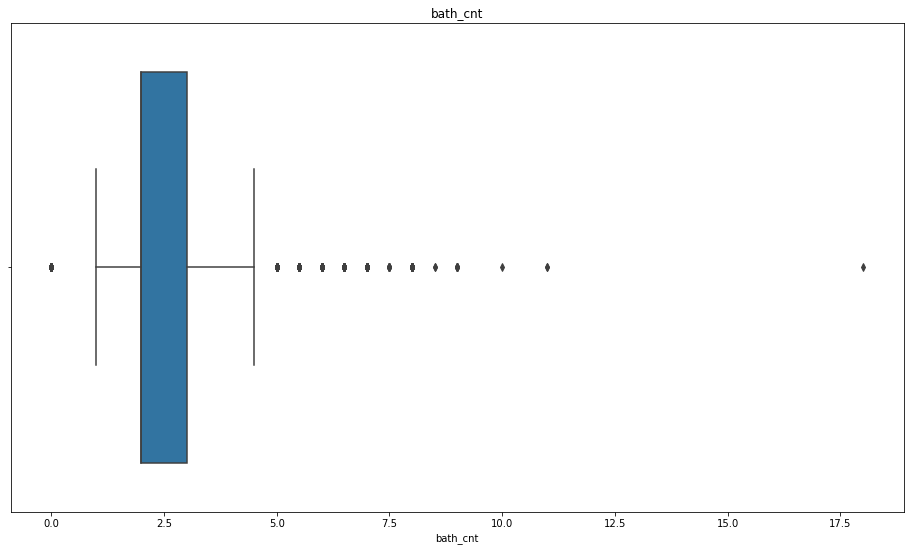

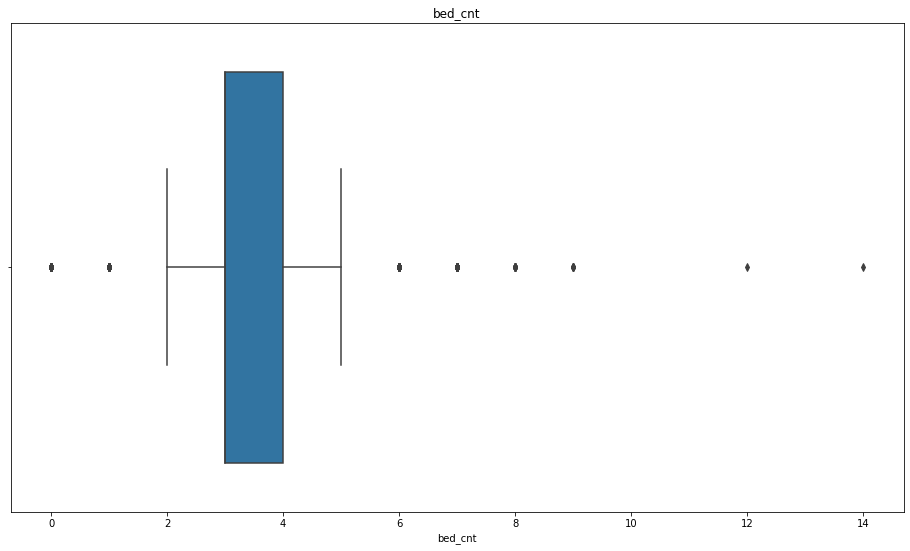

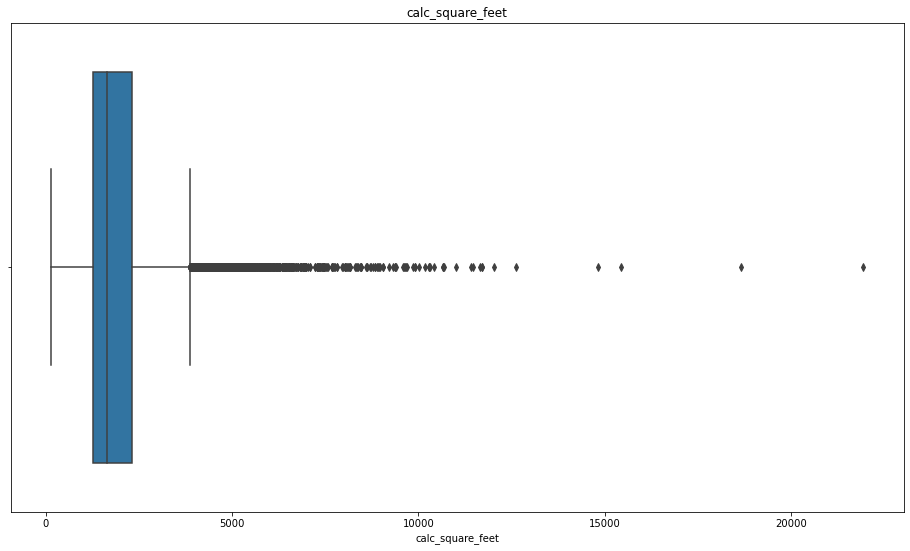

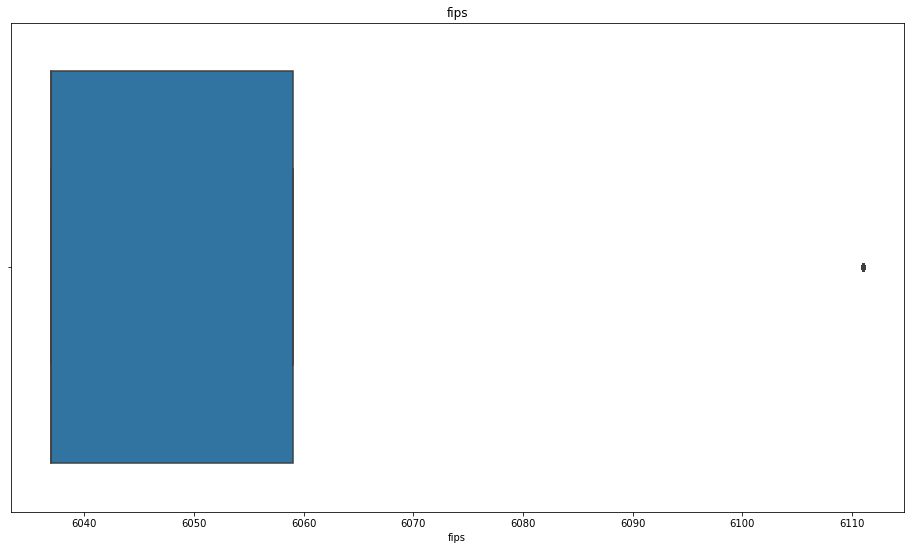

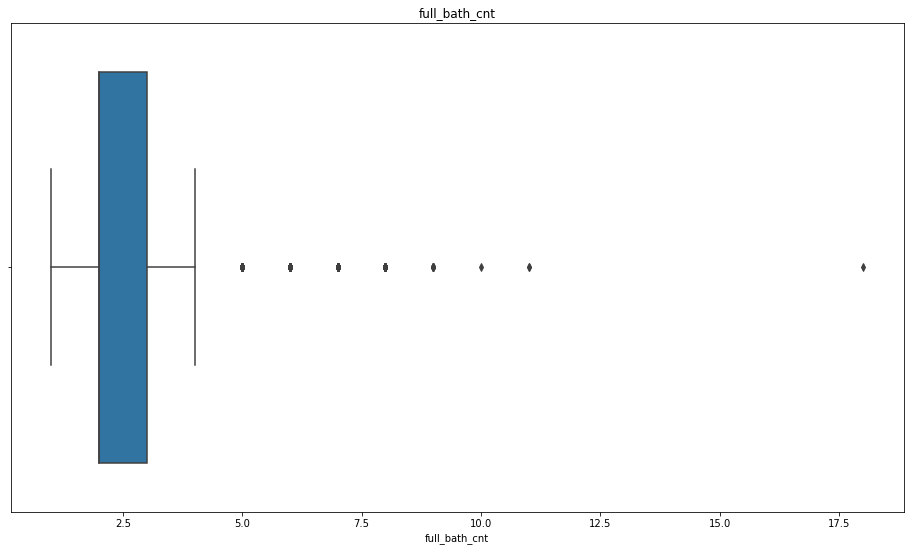

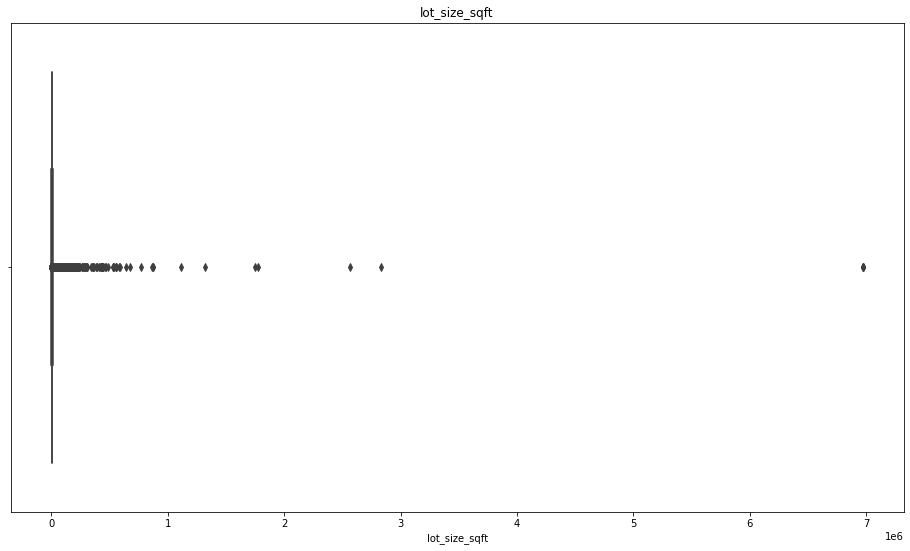

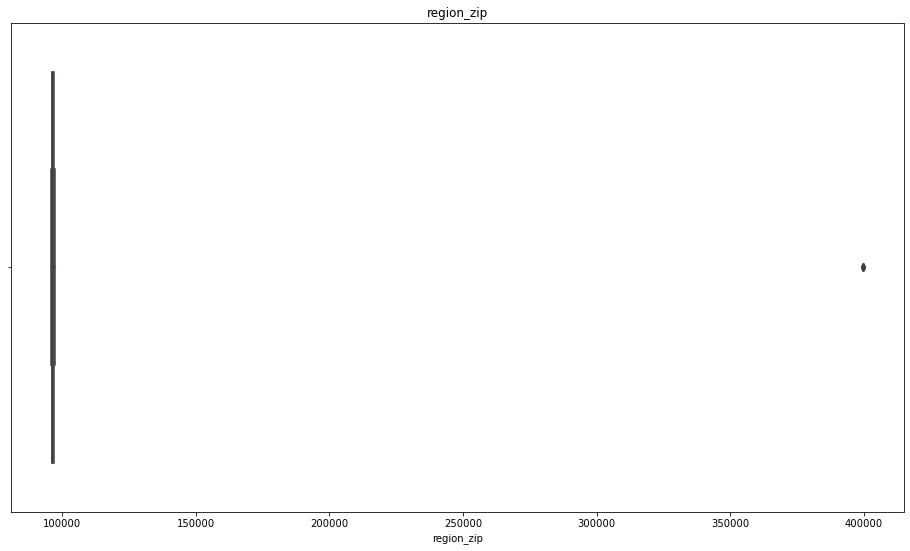

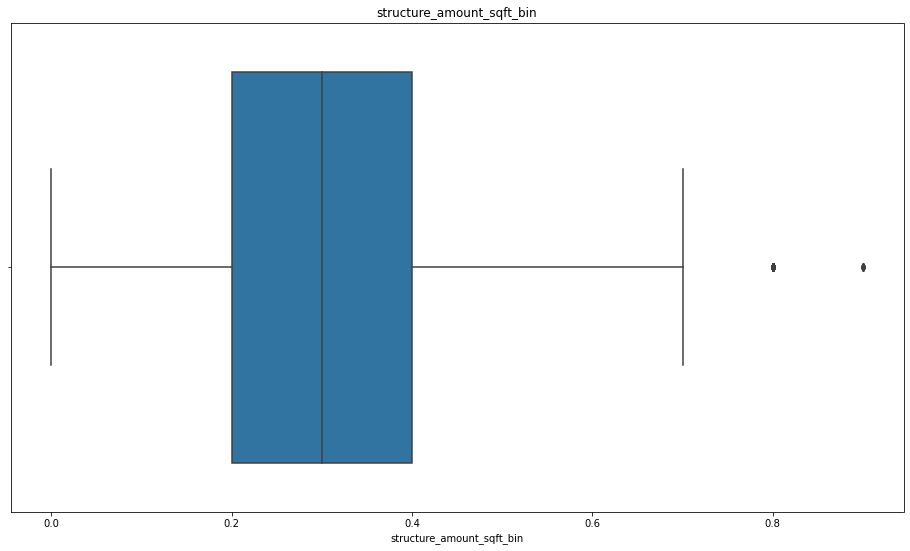

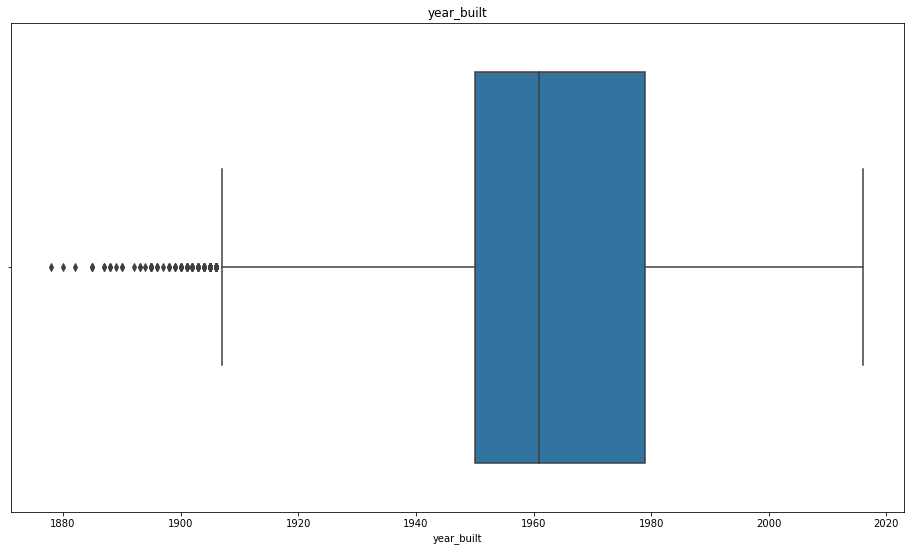

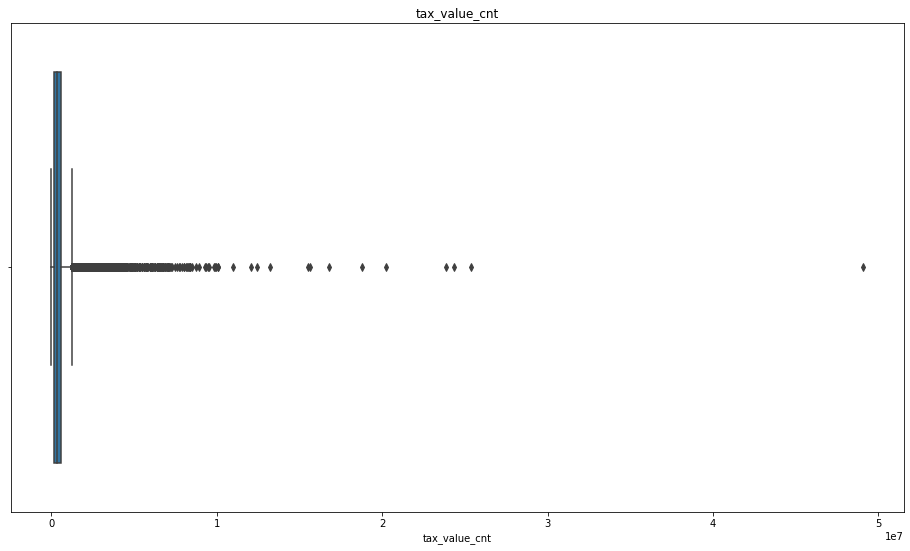

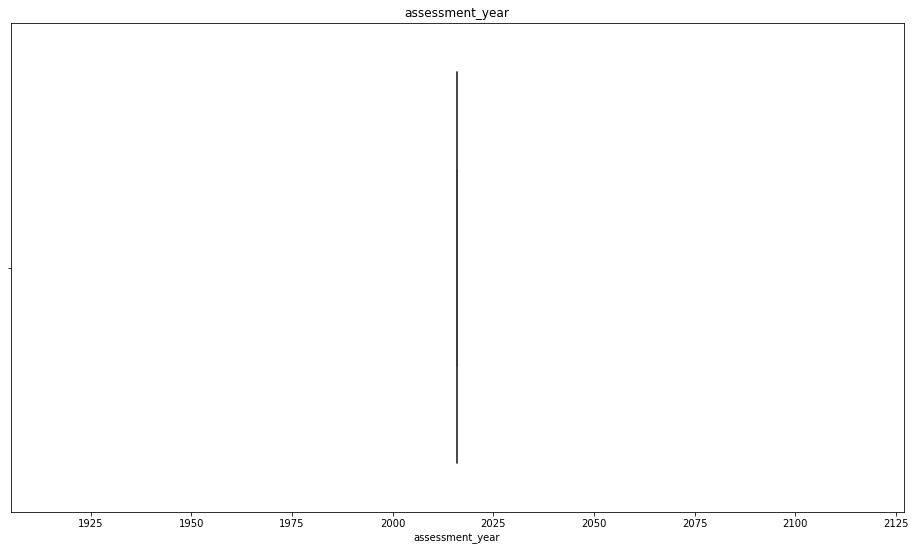

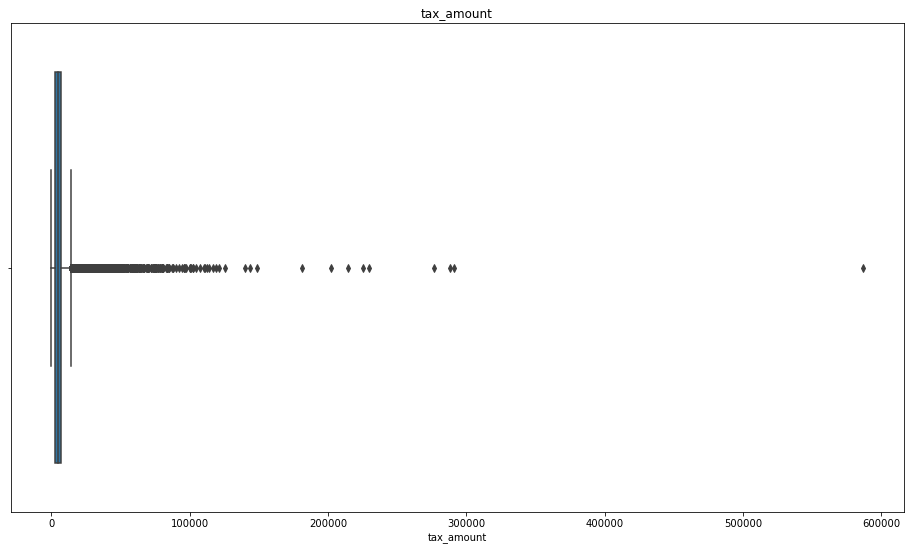

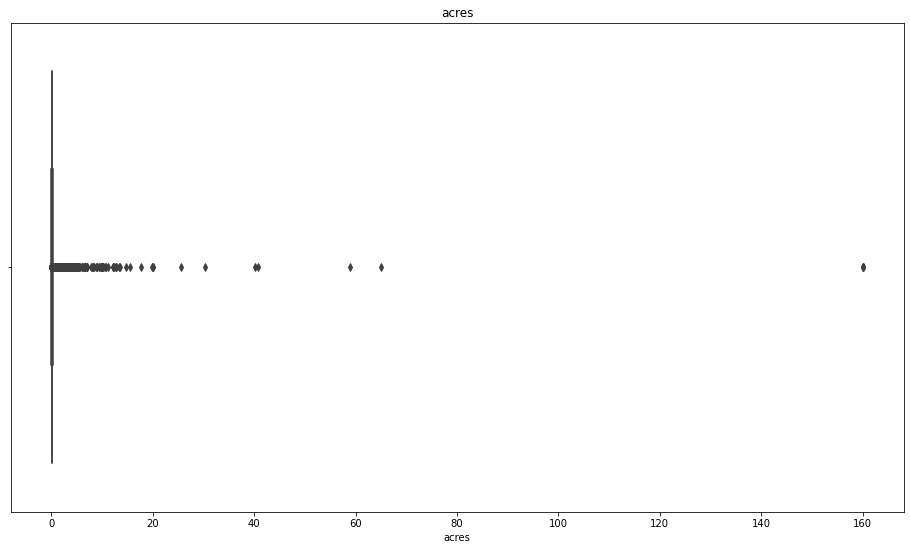

In [405]:
## Check the visualizations

for col in train[['bath_cnt', 'bed_cnt', 'calc_square_feet', 
                  'fips', 'full_bath_cnt','lot_size_sqft', 
                 'region_zip', 'structure_amount_sqft_bin',
                  'year_built',
                  'tax_value_cnt', 'assessment_year','tax_amount', 
                  'acres']]:
    
    plt.figure(figsize = (16,9))
    sns.boxplot(train[col], orient='h')
    plt.title(col)
    plt.show()


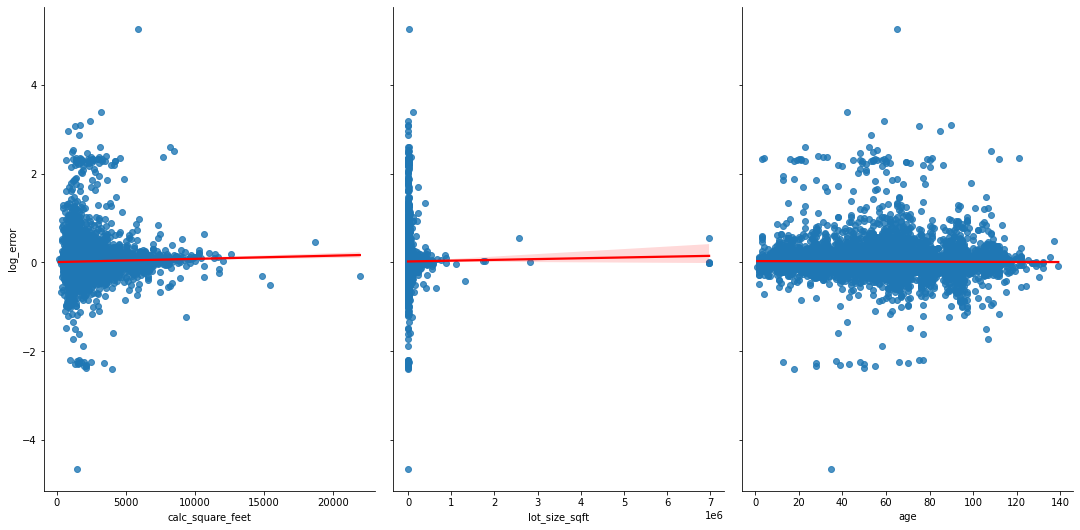

In [407]:
g = sns.pairplot(train, kind='reg', plot_kws={'line_kws':{'color':'red'}}, x_vars = ['calc_square_feet', 'lot_size_sqft', 'age'], 
                 y_vars = ['log_error'])

g.fig.set_size_inches(16, 9)

### Homes Age Distribution 

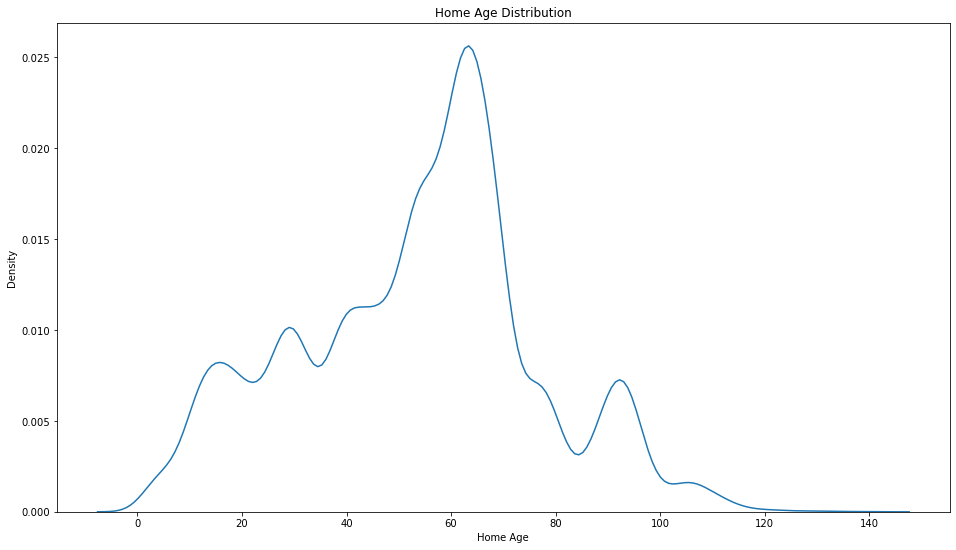

In [399]:
plt.figure(figsize = (16, 9))
sns.kdeplot(train.age)
plt.title('Home Age Distribution')
plt.xlabel('Home Age')
plt.show()

> ### Observations:
> ##### There are outliers in the following fields and we will strip extremes
> - Strip bed count over 8
> - Strip bath above 7.5
> - Strip square feet above to 12000
> - Strip full bath above 6
> - Strip latitude abouve 3.48
> - Strip longitude below -1.1910
> - Strip lot size square feet above 1
> - Strip census track and block above 6.06
> - Strip region id city above 130,000
> - Strip region zip above 100,000
> - Strip unit count above 1.25
> - Strip year built before 1910
> - Strip structure tac value count above 4
> - Strip tax value count above 2
> - Strip land tax value count above 2
> - Strip tax amount above 300,000
> - Strip census track block over 2

### Strip Outliers (above list)

In [28]:
# # Strip outliers on all three sets

# train_stripped_ouliers = wrangle.strip_outliers(train)
# validate_stripped_ouliers = wrangle.strip_outliers(validate)
# test_stripped_ouliers= wrangle.strip_outliers(test)

In [30]:
# train_stripped_ouliers.head()

## Question 1: Lot size (acres) on Z-estimate? 

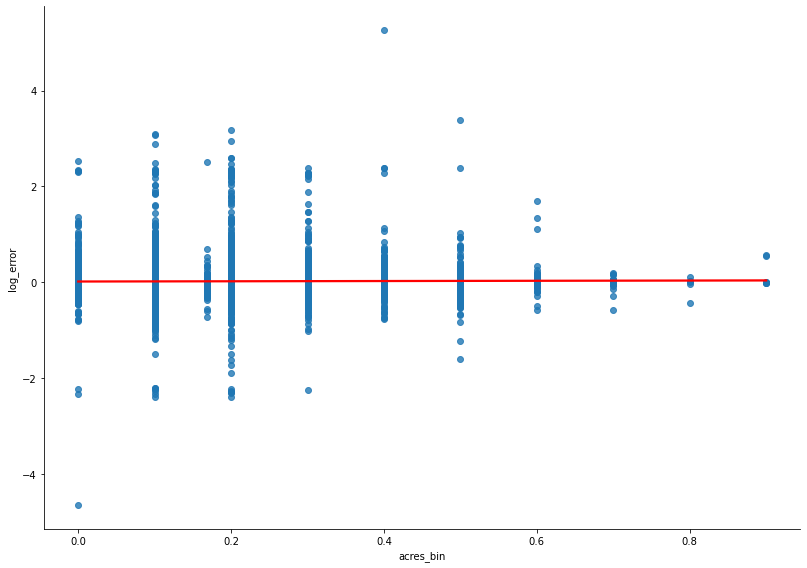

In [32]:
# Create lmplot showing regression

sns.lmplot(x="acres_bin", y="log_error", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

> - ## T-Test (alpha = 0.05)

##### H0 = 'There is no correlation between homes land size and z-estimate error'
##### H1 = 'Homes land size affects z-estimate error'


> ### Correlations Rubric
> - __Perfect:__ If the value is near ± 1, then it said to be a perfect correlation: as one variable increases, the other variable tends to also increase (if positive) or decrease (if negative).
> - __High degree:__ If the coefficient value lies between ± 0.50 and ± 1, then it is said to be a strong correlation.
> - __Moderate degree:__ If the value lies between ± 0.30 and ± 0.49, then it is said to be a medium correlation.
> - __Low degree:__ When the value lies below + .29, then it is said to be a small correlation.
> - __No correlation:__ When the value is zero.

In [33]:
H0 = 'There is no correlation between homes land size and z-estimate error'
H1 = 'Homes land size affects z-estimate error'

alpha = 0.05

# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.

r, p = pearsonr(train.lot_size_sqft, train.log_error)

print(f'\n\n\tCorrelation Coefficient: {r}\n\tP-value: {p}\n')



	Correlation Coefficient: 0.00932127900312308
	P-value: 0.08795182596263658



In [34]:
if p / 2 < alpha:
    print(f"\n\tFAILED TO REJECT:- {H0}\n")
else:
    print(f"\n\tREJECT:- {H0}\n")



	FAILED TO REJECT:- There is no correlation between homes land size and z-estimate error



> - ### Question 1 Conclusion: 
- ##### Lot size has very low degree of correlation with log error (0.009).


## Question 2: How does home square feet affect z-estimate?

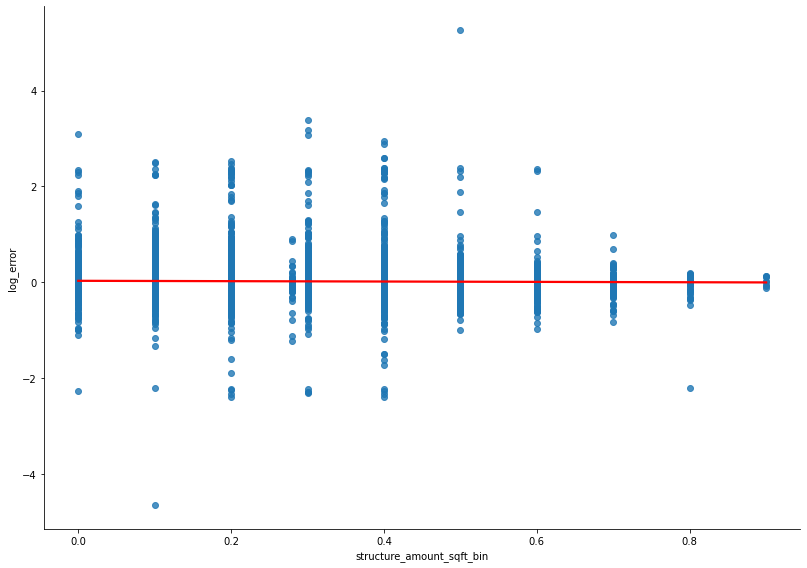

In [47]:
# Create lmplot showing regression
sns.lmplot(x="structure_amount_sqft_bin", y="log_error", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

> ## T-Test

In [79]:
H0 = 'There is no correlation between homes square feet and z-estimate error'
H1 = 'Homes square feet affects z-estimate error'

alpha = 0.05

# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.

r, p = pearsonr(train.sqft_bin, train.log_error)

print(f'\n\n\tCorrelation Coefficient: {r}\n\tP-value: {p}\n')



	Correlation Coefficient: 0.03254992729059045
	P-value: 2.524527970206443e-09



In [80]:
if p / 2 < alpha:
    print(f"\n\tFAILED TO REJECT:- {H0}\n")
else:
    print(f"\n\tREJECT:- {H0}\n")


	FAILED TO REJECT:- There is no correlation between homes square feet and z-estimate error



> - ### Question 2 Conclusion: 
- ##### Lot size has moderate degree of correlation with log error __(0.032).__


## Question 3: Controlling location by counties, how does the home lot size affect  z-estimate affected?



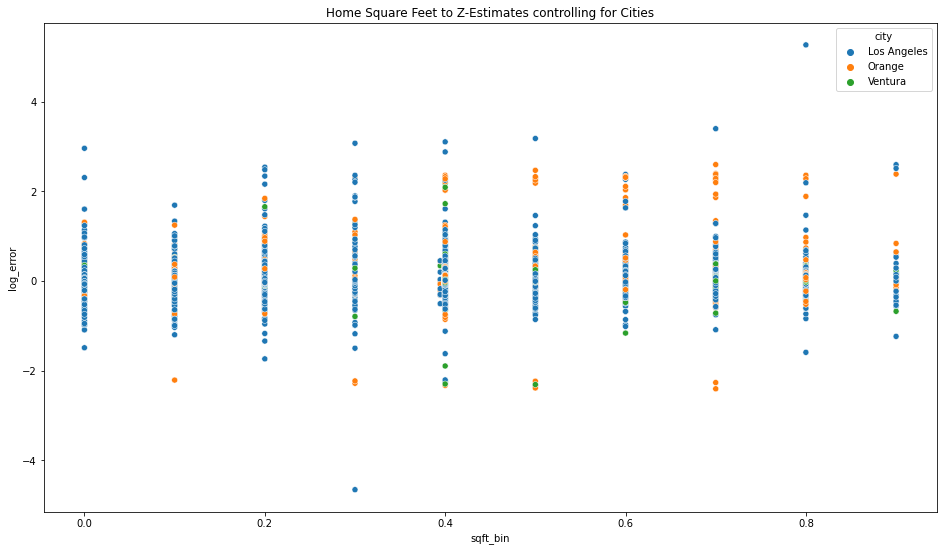

In [84]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x='sqft_bin', y='log_error', data=train, hue='city')
plt.title('Home Square Feet to Z-Estimates controlling for Cities')
plt.show()

In [88]:
H_0 = 'There is no correlation between different cities homes square feet and z-estimate error'
H_1 = 'Homes square feet in different cities affects z-estimate error same way'

stat, p = stats.levene(train[train.city == 'Los Angeles'].lot_size_sqft, 
             train[train.city == 'Orange'].lot_size_sqft, 
             train[train.city == 'Ventura'].lot_size_sqft)

stat, p

(7.92465708679061, 0.00036239222553923633)

In [89]:
if p / 2 < alpha:
    
    print(f"\n\tFAILED TO REJECT:- {H_0}\n")
else:
    print(f"\n\tREJECT:- {H_0}\n")


	FAILED TO REJECT:- There is no correlation between different cities homes square feet and z-estimate error



> - ### Question 3 Conclusion: 
- ##### Lot size has moderate degree of correlation with log error __(0.000362).__

### Question 4: Controlling tax value, how is the z-estimate affected?


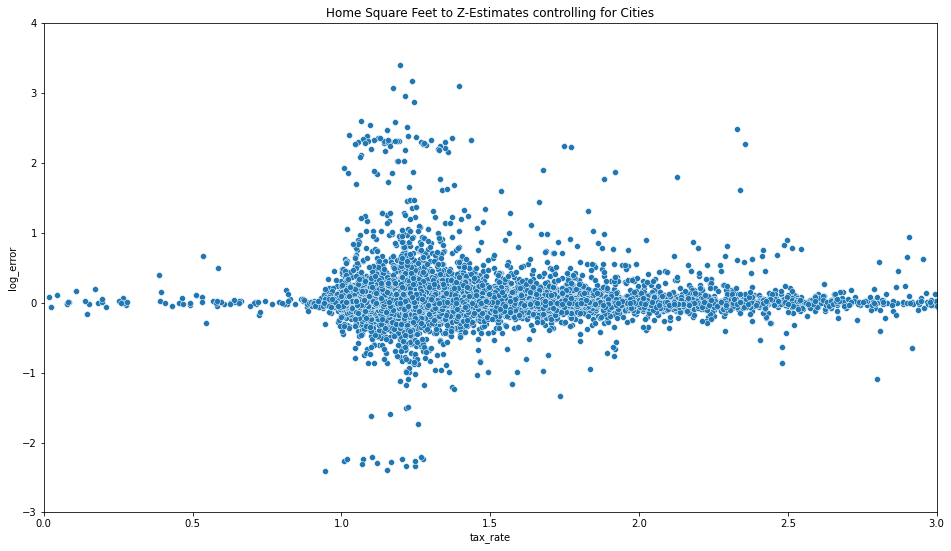

In [110]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x='tax_rate', y='log_error', data = train)
plt.title('Home Square Feet to Z-Estimates controlling for Cities')
plt.xlim(0, 3)
plt.ylim(-3, 4)
plt.show()

### Question 4: Lastly how are the age of the homes in counties affect z-estimates counties?

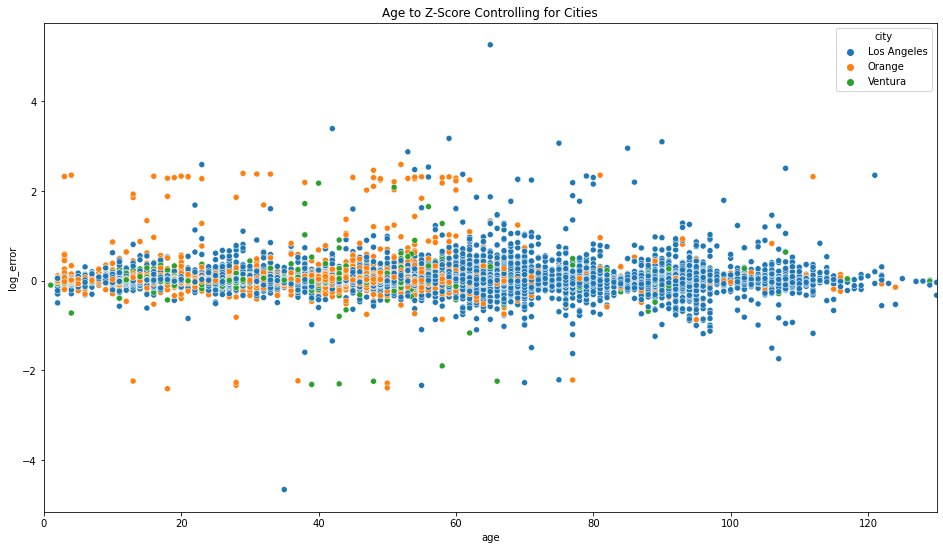

In [118]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x='age', y='log_error', data=train, hue = 'city')
plt.title('Age to Z-Score Controlling for Cities')
plt.xlim(0, 130)
plt.show()

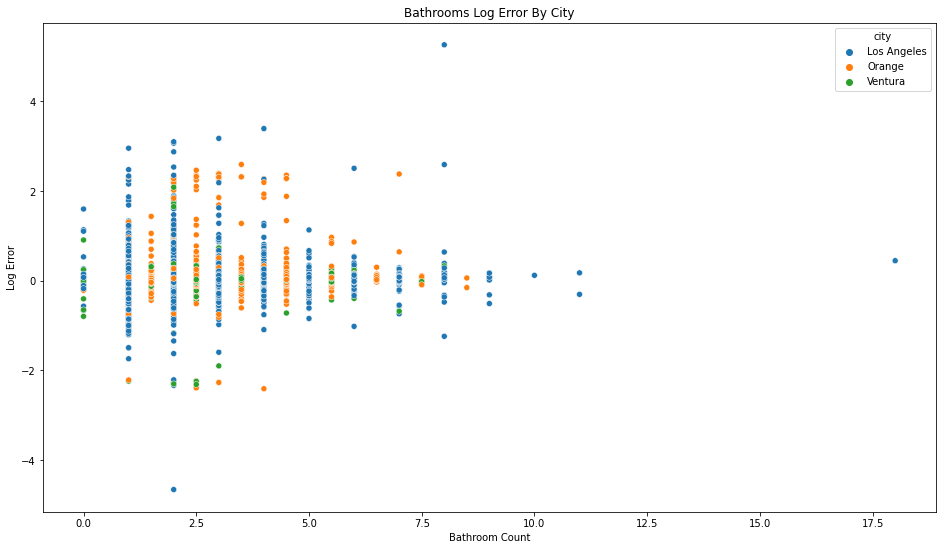

In [117]:
plt.figure(figsize = (16, 9))
plt.title("Bathrooms Log Error By City")
sns.scatterplot(x="bath_cnt", y="log_error", data = train, hue="city" )
population_survival_rate = train.log_error.mean()
plt.ylabel('Log Error')
plt.xlabel('Bathroom Count')
plt.show()

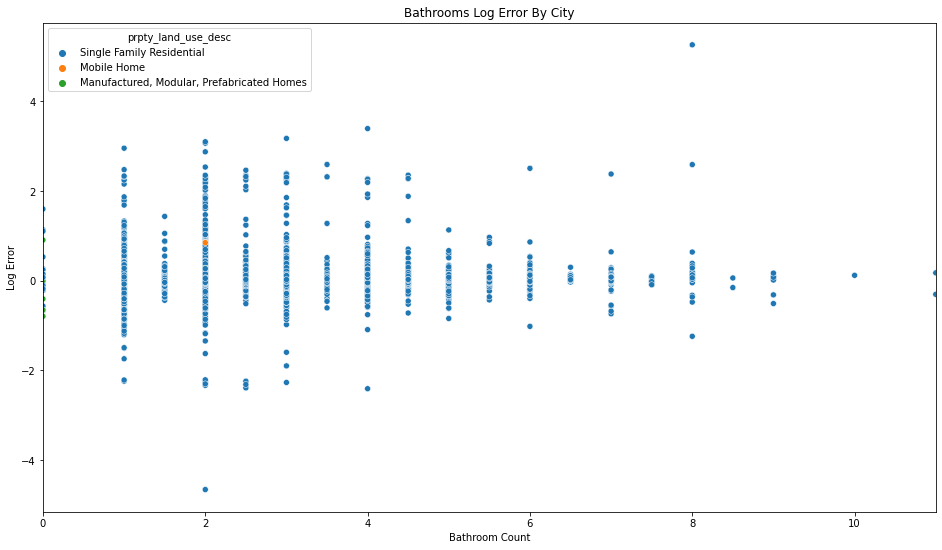

In [154]:
plt.figure(figsize = (16, 9))
plt.title("Bathrooms Log Error By City")
sns.scatterplot(x="bath_cnt", y="log_error", data = train, hue="prpty_land_use_desc" )
population_survival_rate = train.log_error.mean()
plt.ylabel('Log Error')
plt.xlabel('Bathroom Count')
plt.xlim(0.0, 11.0)
plt.show()

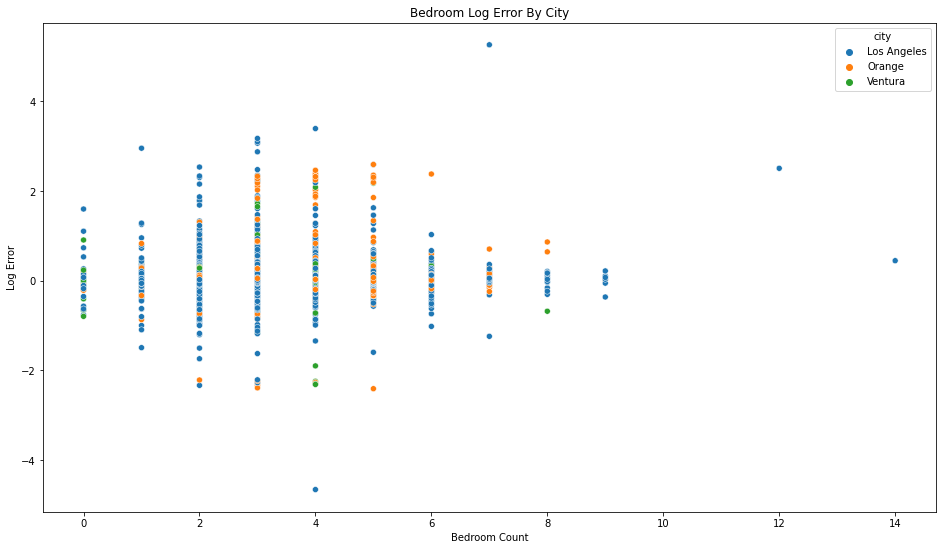

In [120]:
plt.figure(figsize = (16, 9))
plt.title("Bedroom Log Error By City")
sns.scatterplot(x="bed_cnt", y="log_error", data = train, hue="city" )
population_survival_rate = train.log_error.mean()
plt.ylabel('Log Error')
plt.xlabel('Bedroom Count')
plt.show()

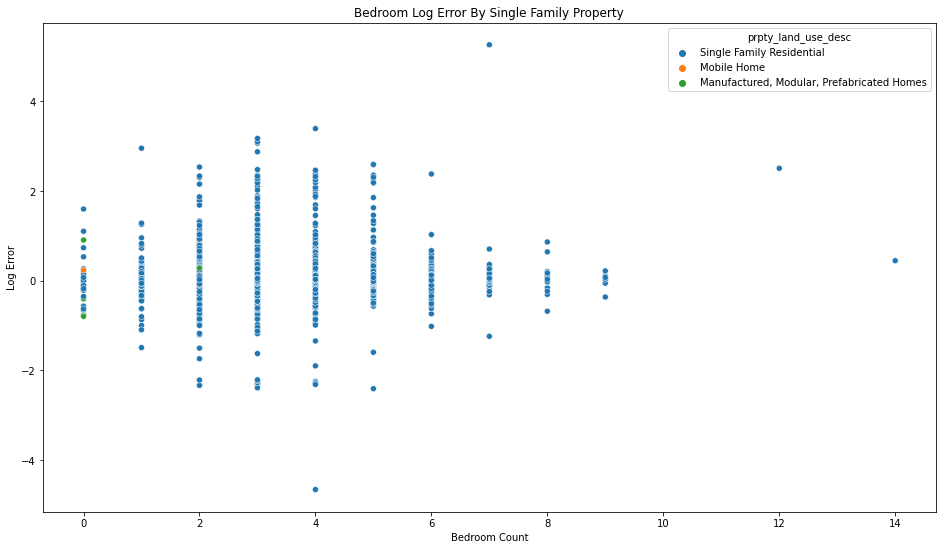

In [121]:
plt.figure(figsize = (16, 9))
plt.title("Bedroom Log Error By Single Family Property")
sns.scatterplot(x="bed_cnt", y="log_error", data = train, hue="prpty_land_use_desc" )
population_survival_rate = train.log_error.mean()
plt.ylabel('Log Error')
plt.xlabel('Bedroom Count')
plt.show()

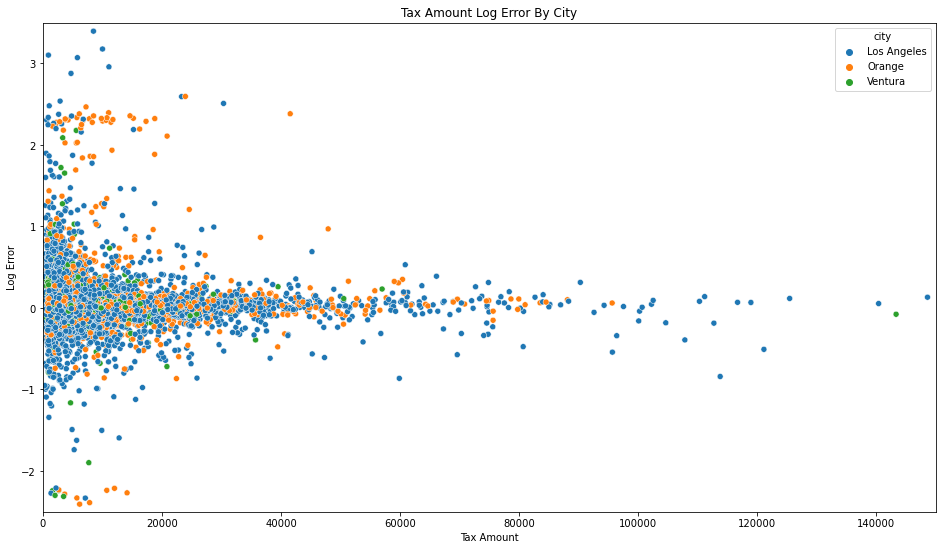

In [155]:
plt.figure(figsize = (16, 9))
plt.title("Tax Amount Log Error By City")
sns.scatterplot(x="tax_amount", y="log_error", data = train, hue="city" )
population_survival_rate = train.log_error.mean()
plt.ylabel('Log Error')
plt.xlabel('Tax Amount')
plt.xlim(0, 150000)
plt.ylim(-2.5, 3.5)
plt.show()

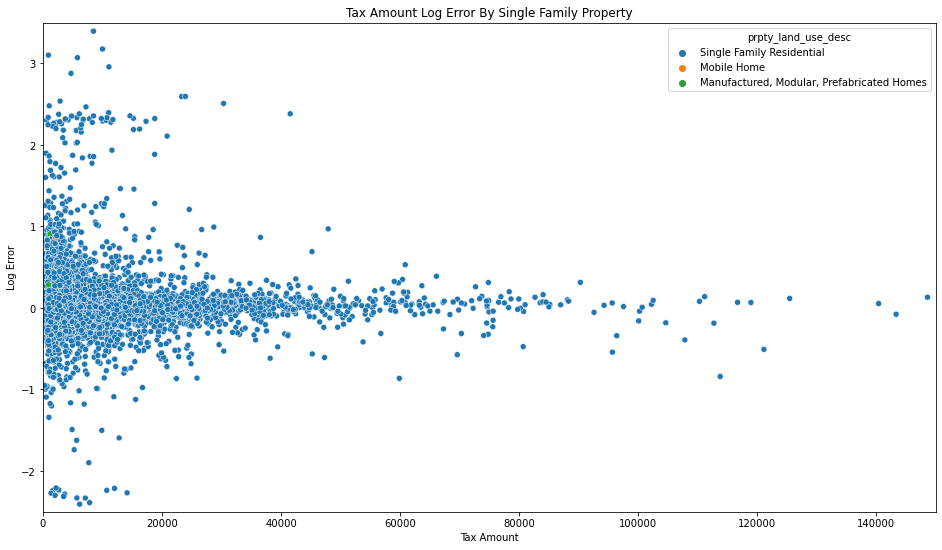

In [147]:
plt.figure(figsize = (16, 9))
plt.title("Tax Amount Log Error By Single Family Property")
sns.scatterplot(x="tax_amount", y="log_error", data = train, hue="prpty_land_use_desc" )
population_survival_rate = train.log_error.mean()
plt.ylabel('Log Error')
plt.xlabel('Tax Amount')
plt.xlim(0, 150000)
plt.ylim(-2.5, 3.5)
plt.show()

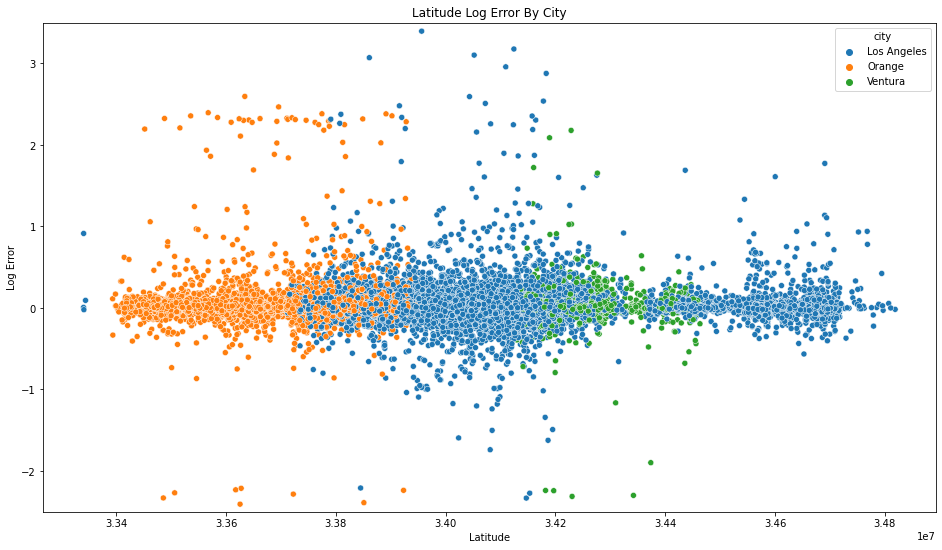

In [148]:
plt.figure(figsize = (16, 9))
plt.title("Latitude Log Error By City")
sns.scatterplot(x="lat", y="log_error", data = train, hue="city" )
population_survival_rate = train.log_error.mean()
plt.ylabel('Log Error')
plt.xlabel('Latitude')
plt.ylim(-2.5, 3.5)
plt.show()

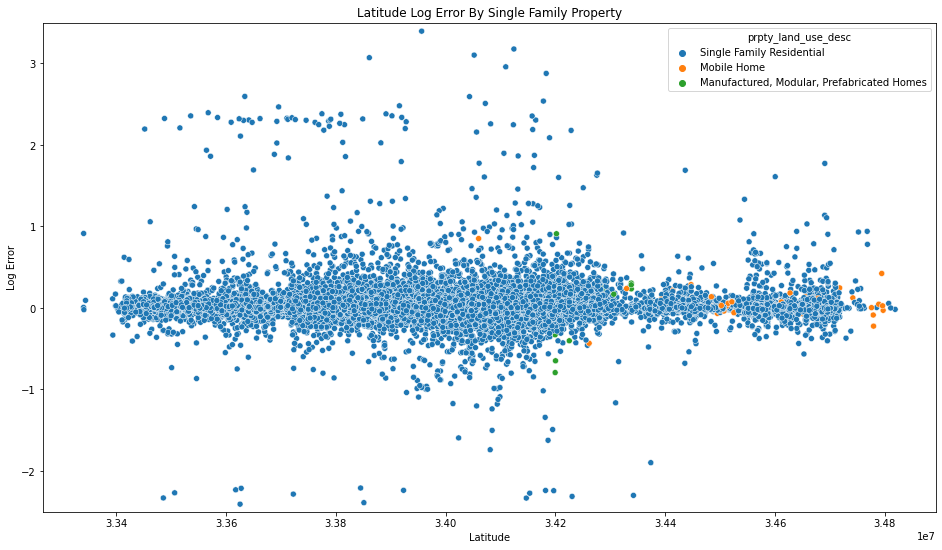

In [149]:
plt.figure(figsize = (16, 9))
plt.title("Latitude Log Error By Single Family Property")
sns.scatterplot(x="lat", y="log_error", data = train, hue="prpty_land_use_desc" )
population_survival_rate = train.log_error.mean()
plt.ylabel('Log Error')
plt.xlabel('Latitude')
plt.ylim(-2.5, 3.5)
plt.show()

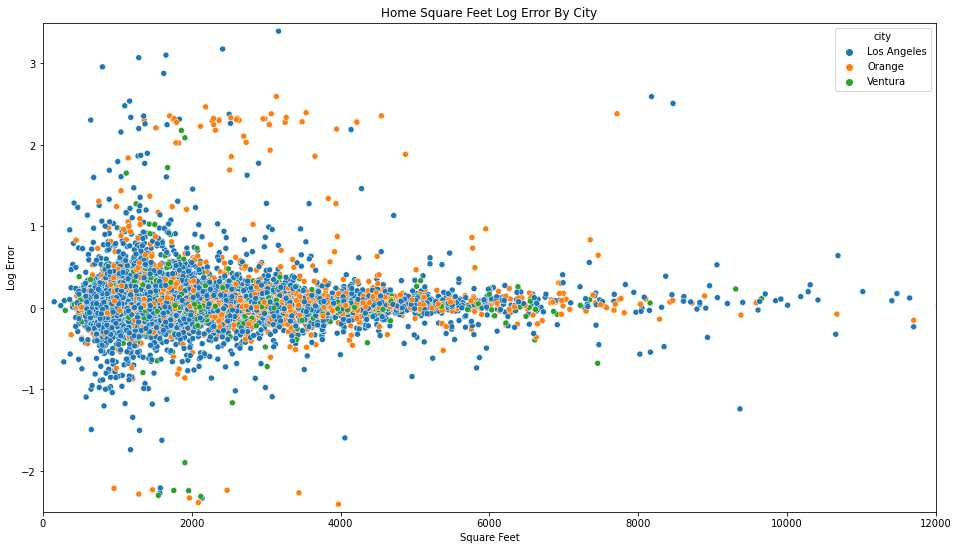

In [150]:
plt.figure(figsize = (16, 9))
plt.title("Home Square Feet Log Error By City")
sns.scatterplot(x="calc_square_feet", y="log_error", data = train, hue="city" )
population_survival_rate = train.log_error.mean()
plt.ylabel('Log Error')
plt.xlabel('Square Feet')
plt.xlim(0, 12000)
plt.ylim(-2.5, 3.5)
plt.show()

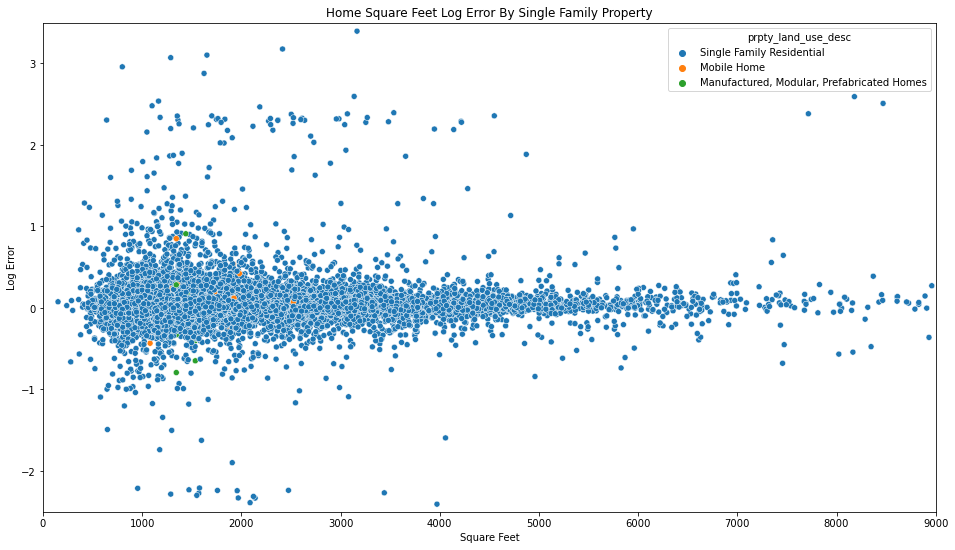

In [132]:
plt.figure(figsize = (16, 9))
plt.title("Home Square Feet Log Error By Single Family Property")
sns.scatterplot(x="calc_square_feet", y="log_error", data = train, hue="prpty_land_use_desc" )
population_survival_rate = train.log_error.mean()
plt.ylabel('Log Error')
plt.xlabel('Square Feet')
plt.xlim(0, 9000)
plt.ylim(-2.5, 3.5)
plt.show()

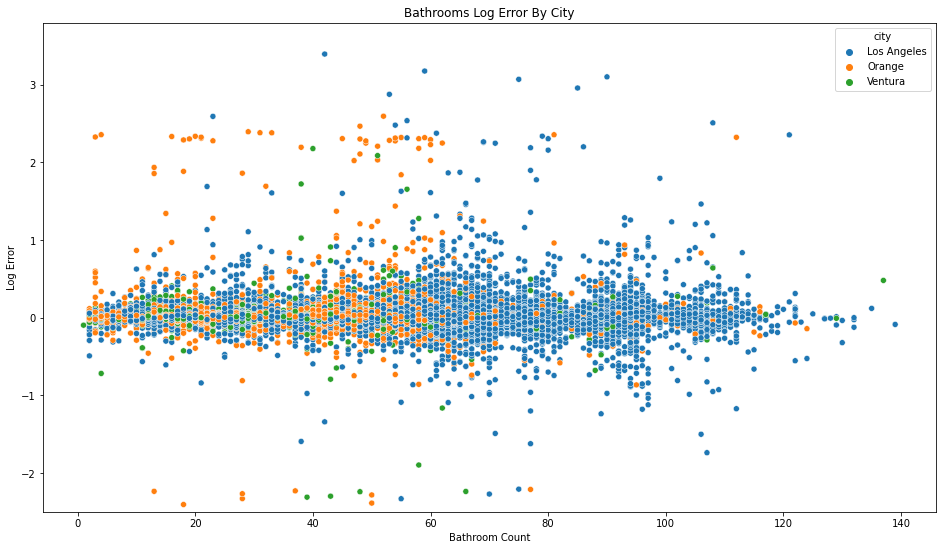

In [133]:
plt.figure(figsize = (16, 9))
plt.title("Bathrooms Log Error By City")
sns.scatterplot(x="age", y="log_error", data = train, hue="city")
population_survival_rate = train.log_error.mean()
plt.ylabel('Log Error')
plt.xlabel('Bathroom Count')
plt.ylim(-2.5, 3.8)
plt.show()

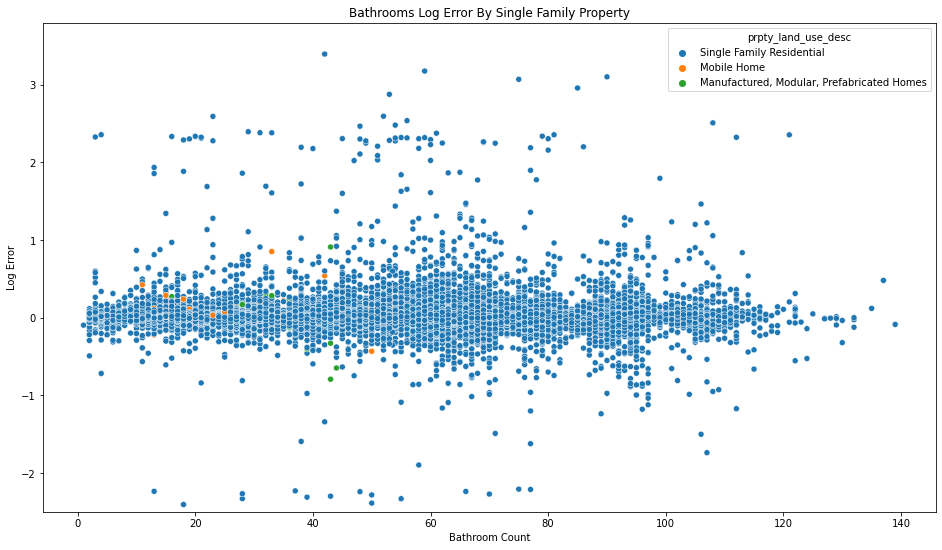

In [152]:
plt.figure(figsize = (16, 9))
plt.title("Bathrooms Log Error By Single Family Property")
sns.scatterplot(x="age", y="log_error", data = train, hue="prpty_land_use_desc" )
population_survival_rate = train.log_error.mean()
plt.ylabel('Log Error')
plt.xlabel('Bathroom Count')
plt.ylim(-2.5, 3.8)
plt.show()

## Exploration TakeAways

>### Top 20 drivers (Select K-Best) for Z-estimates are:
- 'bath_cnt', 'bed_cnt', 'calc_square_feet', 'fips', 
- 'full_bath_cnt','lat', 'longt', 'lot_size_sqft', 
- 'census_tract_and_block','region_id_city', 'region_zip', 
- 'room_cnt', 'unit_cnt', 'year_built','structure_tax_value_cnt', 
- 'tax_value_cnt', 'assessment_year','land_tax_value_cnt', 
- 'tax_amount', 'census_tract_block', Log Error is greatest 


>### Error is greatest:
- Bed count 2-4 followed by 5 and 1
- Bathroom counts 1, 2, 3, 4
- Tax rate between 1.0- 1.5 and skews right to 3.0 (tax rate = tax amount / tax count)
- Los Angeles has higher tax rate followed by Orange and least Ventura
- Latitude and Longitude have even distribution of longitude
- Homes with square feet around 1500 have high log errors, skews right to about 6000 square feet.
- Majority of 1500 square feet homes with high log-errors are in Los Angeles, followed by Orange County. 

- Age of home has evenly distributed log-error over the years


## Create Scaled Data Columns  (MinMaxScaler)

In [449]:
def scale_data(train, validate, test):
    # Scaling function 
    
    columns_to_scale = ['bath_cnt','bed_cnt','age', 'lot_size_sqft','calc_square_feet',  'tax_amount']
    
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()

    scaler = MinMaxScaler()
    scaler.fit(train[columns_to_scale])

    train_scaled[columns_to_scale] = scaler.transform(train[columns_to_scale])
    validate_scaled[columns_to_scale] = scaler.transform(validate[columns_to_scale])
    test_scaled[columns_to_scale] = scaler.transform(test[columns_to_scale])

    return train_scaled, validate_scaled, test_scaled


In [450]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test)

In [451]:
train_scaled.head(3)

,bath_cnt,bed_cnt,calc_square_feet,fips,full_bath_cnt,lat,longt,lot_size_sqft,census_tract_and_block,region_id_city,...,sqft_bin,bedrooms_bin,structure_amount_per_sqft,structure_amount_sqft_bin,land_amount_per_sqft,lot_amount_sqft_bin,bath_bed_ratio,cola,cluster,bed_age_lot_cluster
30541,0.055556,0.214286,0.063278,6037.0,1.0,34532401.0,-117969992.0,0.001562,6.037910e+07,29189.0,...,0.4,0.3,27.658824,0.1,0.202320,0.0,0.333333,0,1,1
23571,0.111111,0.214286,0.059466,6059.0,2.0,33774197.0,-117891429.0,0.000838,6.059089e+07,47568.0,...,0.3,0.3,78.345543,0.3,37.959355,0.3,0.666667,0,1,1
19409,0.222222,0.214286,0.105937,6037.0,4.0,34168438.0,-118245692.0,0.000968,6.037301e+07,45457.0,...,0.5,0.3,154.790565,0.5,64.483040,0.4,1.333333,0,0,3


# Clustering 

### (i). 2 Features:- 
>- #### Square Feet
>- #### Tax Amount

In [452]:
X = train_scaled[['calc_square_feet',  'tax_amount']]

In [453]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)

kmeans.predict(X)


array([0, 0, 1, ..., 0, 2, 0], dtype=int32)

In [454]:
train_scaled['sqft_tax_cluster'] = kmeans.predict(X)


### Visualize Clusters

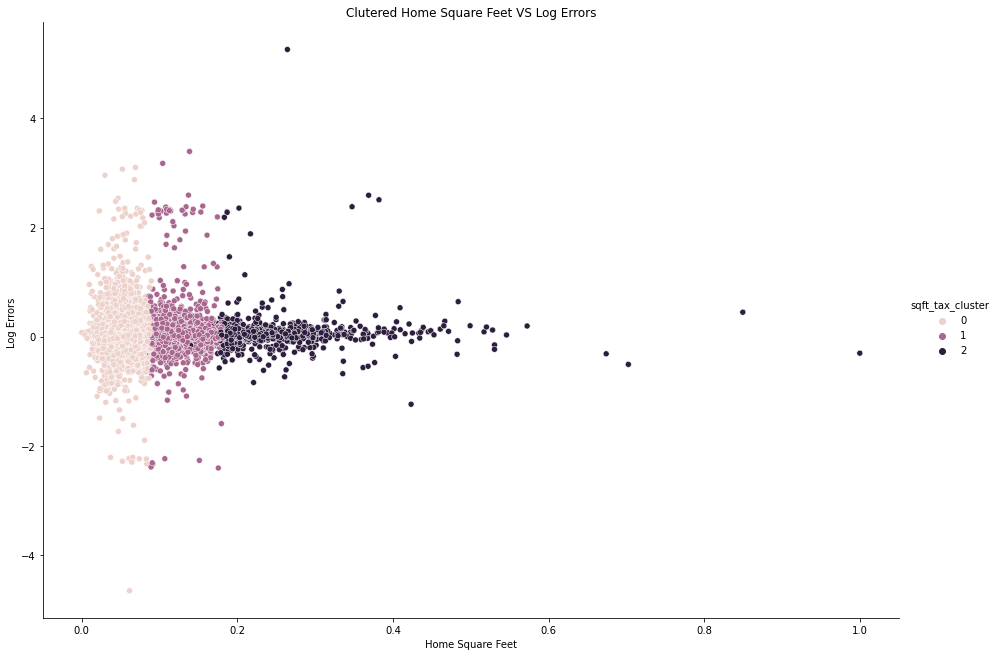

In [455]:
# plt.figure(figsize=(16, 9))
# plt.rc('font', size=13)

sns.relplot(data = train_scaled, x = 'calc_square_feet', y = 'log_error',
            hue='sqft_tax_cluster', height = 9, aspect = 11.7 / 8.27)

plt.title('Clutered Home Square Feet VS Log Errors')
plt.xlabel('Home Square Feet')
plt.ylabel('Log Errors ')
# plt.xlim(-1000, 12000)
plt.show()

In [300]:
# Cluster for each cluster

kmeans.cluster_centers_

array([[0.05753775, 0.00714141],
       [0.23162431, 0.04802319],
       [0.11798856, 0.01484964]])

In [301]:
# Create centroids object

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)
centroids

,calc_square_feet,tax_amount
0,0.057538,0.007141
1,0.231624,0.048023
2,0.117989,0.014850


In [302]:
# Group by clusters

train_scaled.groupby('sqft_tax_cluster')['log_error','calc_square_feet',  'tax_amount'].mean()


,log_error,calc_square_feet,tax_amount
sqft_tax_cluster,,,
0,0.015074,0.057532,0.007141
1,0.051734,0.231457,0.047921
2,0.022280,0.117950,0.014846


### Cluster Centers

Text(0.5, 1.0, 'Visualizing Cluster Centers')

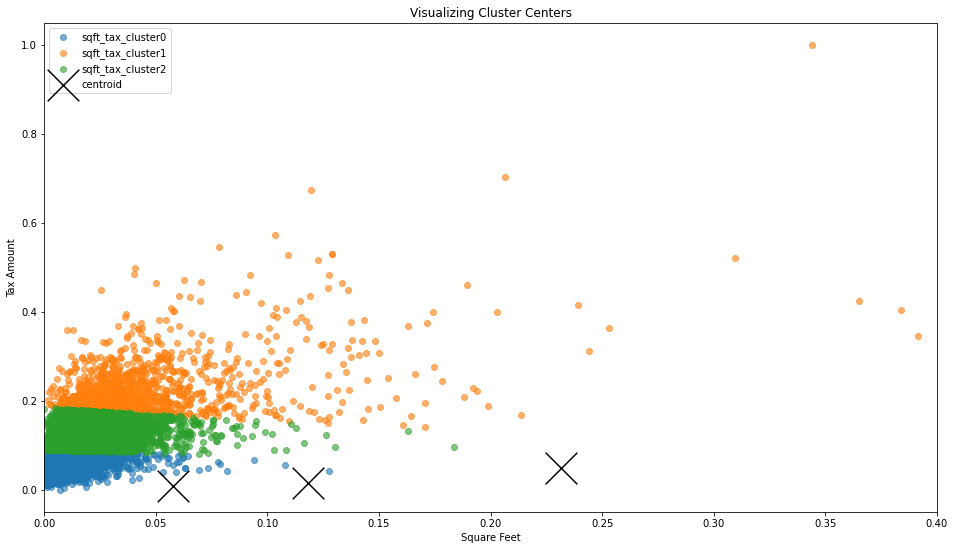

In [303]:
plt.figure(figsize=(16, 9))

for cluster, subset in train_scaled.groupby('sqft_tax_cluster'):
    plt.scatter(subset.tax_amount, subset.calc_square_feet,
                label='sqft_tax_cluster' + str(cluster), alpha=.6)

centroids.plot.scatter(y='tax_amount', x='calc_square_feet',
                       c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlim(0, 0.4)
plt.xlabel('Square Feet')
plt.ylabel('Tax Amount')
plt.title('Visualizing Cluster Centers')


### Elbow Method (Choosing k)

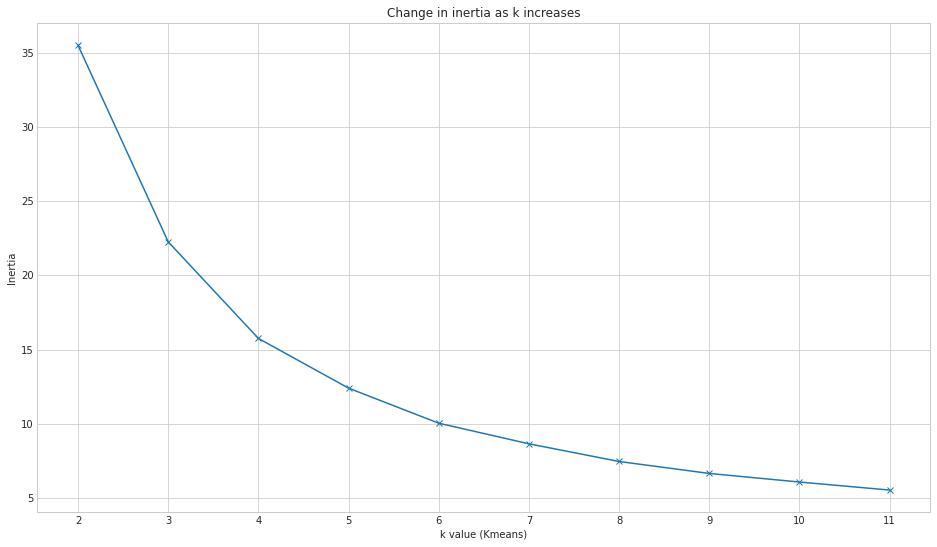

In [304]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(16, 9))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}
              ).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k value (Kmeans)')
    plt.ylabel('Inertia')
    plt.title('Change in inertia as k increases')

### Conclusion:-
- #### (2 features (tax amount and square feet), cluster == 4)

- ##### In the chart above, we notice that the reduction in inertia drops off after about 4 clusters. Based on the above visualization, we might conclude that the optimal number of clusters is 4.

### (ii). 3 Features:- 
>- #### Bed Count
>- #### Age 
>- #### Home Lot Size

In [312]:
X2 = train_scaled[['bed_cnt','age', 'lot_size_sqft']]

Text(0.5, 0.98, "clusters based on ['bed_cnt', 'age', 'lot_size_sqft']")

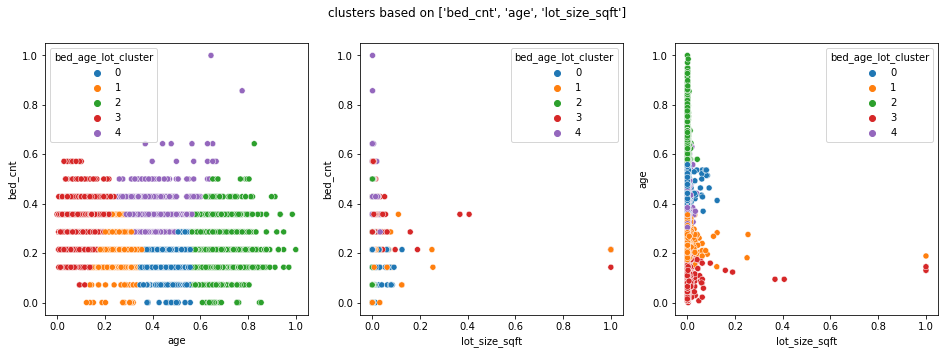

In [318]:
kmeans = KMeans(n_clusters =5)
kmeans.fit(X2)
train_scaled['bed_age_lot_cluster'] = kmeans.labels_
train_scaled.bed_age_lot_cluster = train_scaled.bed_age_lot_cluster.astype('category')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

sns.scatterplot(data=train_scaled, y='bed_cnt', x='age', hue='bed_age_lot_cluster', ax=ax1)
sns.scatterplot(data=train_scaled, y='bed_cnt', x='lot_size_sqft', hue='bed_age_lot_cluster', ax=ax2)
sns.scatterplot(data=train_scaled, y='age', x='lot_size_sqft', hue='bed_age_lot_cluster', ax=ax3)
fig.suptitle(f'clusters based on {X2.columns.tolist()}')

In [319]:
# Group by clusters

train_scaled.groupby('bed_age_lot_cluster')['log_error','bed_cnt','age', 'lot_size_sqft'].mean()

,log_error,bed_cnt,age,lot_size_sqft
bed_age_lot_cluster,,,,
0,0.015910,0.196403,0.456616,0.001256
1,0.017382,0.231166,0.264169,0.001861
2,0.008542,0.194991,0.663507,0.001026
3,0.024075,0.288724,0.114929,0.002834
4,0.027361,0.306982,0.401664,0.001457


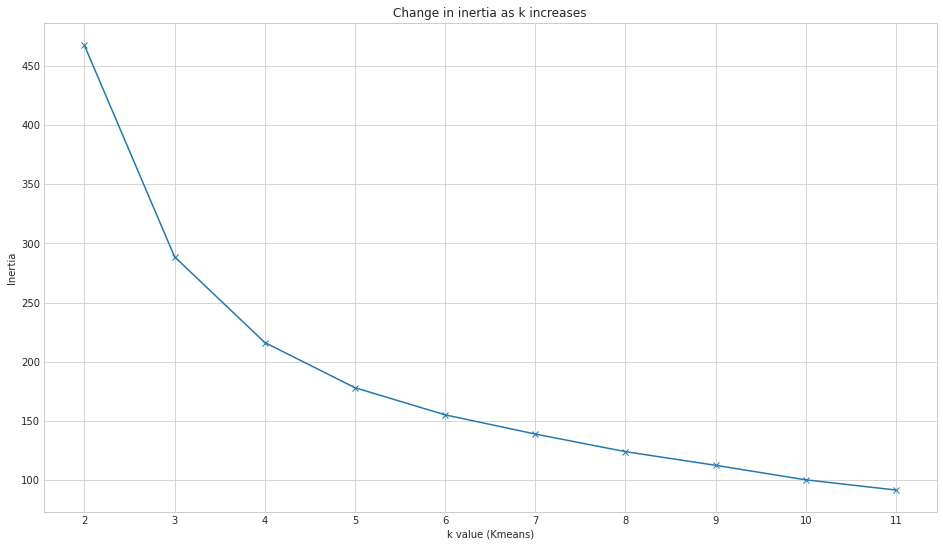

In [320]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(16, 9))
    pd.Series({k: KMeans(k).fit(X2).inertia_ for k in range(2, 12)}
              ).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k value (Kmeans)')
    plt.ylabel('Inertia')
    plt.title('Change in inertia as k increases')

## Clustering Takeaways:

>- #### Inertia drops at 4, number of clusters is 4

# (E). Modeling

> ### Create Baseline

In [456]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict log_error_pred_mean
log_error_pred_mean = y_train['log_error'].mean()
y_train['log_error_pred_mean'] = log_error_pred_mean
y_validate['log_error_pred_mean'] = log_error_pred_mean


# 2. RMSE of log_error_pred_mean
rmse_train_bl = mean_squared_error(y_train.log_error, y_train.log_error_pred_mean)**(1/2)
rmse_validate_bl = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_mean)**(1/2)

print("\nRMSE Baseline (Mean)\n\n\tTrain-In-Sample: ", round(rmse_train_bl, 2), 
      "\n\n\tValidate/Out-of-Sample: ", round(rmse_validate_bl, 2))



RMSE Baseline (Mean)

	Train-In-Sample:  0.18 

	Validate/Out-of-Sample:  0.19


>### Actual Vs Predicted Log Error

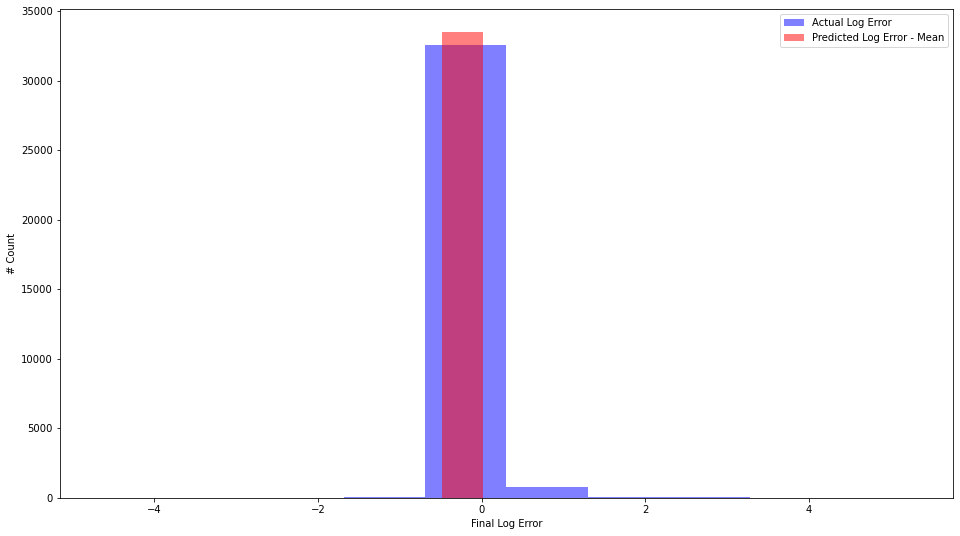

In [457]:
# plot to visualize actual vs predicted. 
plt.figure(figsize = (16, 9))
plt.hist(y_train.log_error, color='blue', alpha=.5, label="Actual Log Error")
plt.hist(y_train.log_error_pred_mean, 
         bins = 2, 
         color ='red', 
         alpha = .5, rwidth = 100, 
         label = "Predicted Log Error - Mean")
plt.xlabel("Final Log Error")
plt.ylabel("# Count")
plt.legend()
plt.show()


## (A). Linear Regression Model

In [458]:
# create the model object
lm = LinearRegression(normalize = True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.log_error)

# predict train
y_train['log_error_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train_lr = mean_squared_error(y_train.log_error, y_train.log_error_pred_lm)**(1/2)

# predict validate
y_validate['log_error_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate_lr = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_lm)**(1/2)

print("\nRMSE for OLS using LinearRegression\n\n\tTraining/In-Sample: ", rmse_train_lr, 
      "\n\n\tValidation/Out-of-Sample: ", rmse_validate_lr)



RMSE for OLS using LinearRegression

	Training/In-Sample:  0.17846797049256063 

	Validation/Out-of-Sample:  0.1883247180785702


### (B). LASSO + LARS


In [459]:
# create the model object
lars = LassoLars(alpha = 1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.log_error)

# predict train
y_train['log_error_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train_ll = mean_squared_error(y_train.log_error, y_train.log_error_pred_lars)**(1/2)

# predict validate
y_validate['log_error_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate_ll = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_lars)**(1/2)

print("RMSE for LASSO + LARS\n\n\tTraining/In-Sample: ", rmse_train_ll, 
      "\n\n\tValidation/Out-of-Sample: ", rmse_validate_ll)


RMSE for LASSO + LARS

	Training/In-Sample:  0.17891862583174264 

	Validation/Out-of-Sample:  0.18846457494367516


### (C). Polynomial Regression


In [460]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree = 2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)


In [461]:
# create the model object
lm2 = LinearRegression(normalize = True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.log_error)

# predict train
y_train['log_error_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_pr = mean_squared_error(y_train.log_error, y_train.log_error_pred_lm2)**(1/2)

# predict validate
y_validate['log_error_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_pr = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\n\n\tTraining/In-Sample: ", rmse_train_pr, 
      "\n\n\tValidation/Out-of-Sample: ", rmse_validate_pr)


RMSE for Polynomial Model, degrees=2

	Training/In-Sample:  0.17924171152759608 

	Validation/Out-of-Sample:  164.80999595289825


## Errors in Predictions

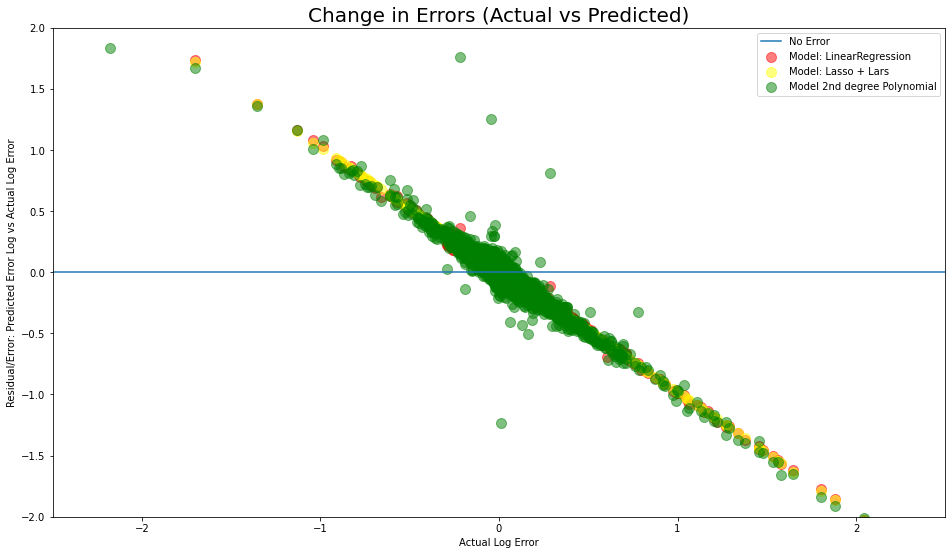

In [462]:
# y_validate.head()
plt.figure(figsize=(16,9))

plt.axhline(label="No Error")

plt.scatter(y_validate.log_error, y_validate.log_error_pred_lm-y_validate.log_error, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")

plt.scatter(y_validate.log_error, y_validate.log_error_pred_lars-y_validate.log_error, 
            alpha=.5, color="yellow", s=100, label="Model: Lasso + Lars")

plt.scatter(y_validate.log_error, y_validate.log_error_pred_lm2-y_validate.log_error, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")

plt.legend()
plt.xlabel("Actual Log Error")
plt.ylabel("Residual/Error: Predicted Error Log vs Actual Log Error")
plt.title("Change in Errors (Actual vs Predicted)", size = 20)
plt.ylim(-2, 2)
plt.xlim(-2.5, 2.5)
plt.show()

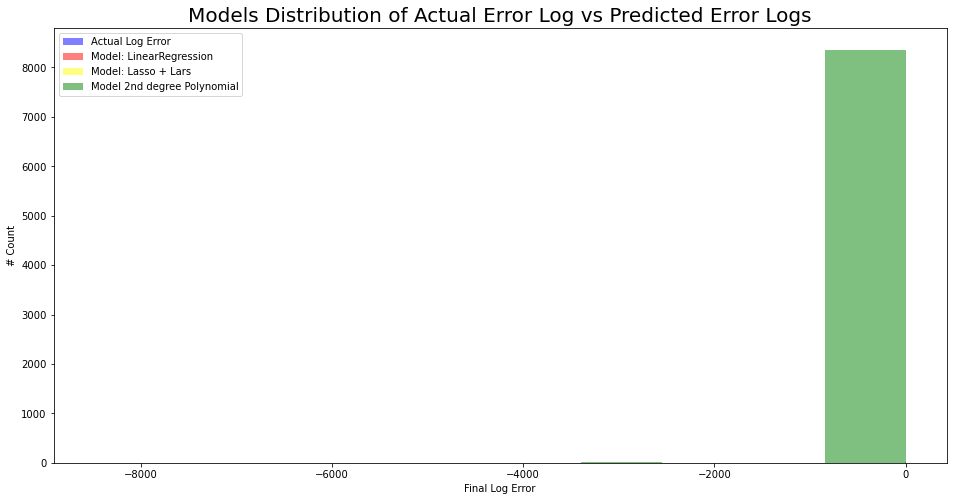

In [463]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.log_error, color='blue', alpha=.5, label="Actual Log Error")
plt.hist(y_validate.log_error_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.log_error_pred_lars, color='yellow', alpha=.5, label="Model: Lasso + Lars")
plt.hist(y_validate.log_error_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Final Log Error")
plt.ylabel("# Count")
plt.title("Models Distribution of Actual Error Log vs Predicted Error Logs", size = 20)
plt.legend()
plt.show()


## Models Results Summary 

In [464]:
print("\n\nRMSE Baseline (Mean)\n\tTrain-In-Sample: ", round(rmse_train_bl, 2), 
      "\n\tValidate/Out-of-Sample: ", round(rmse_validate_bl, 2))

print("\n\nRMSE for OLS using LinearRegression\n\n\tTraining/In-Sample: ", rmse_train_lr, 
      "\n\n\tValidation/Out-of-Sample: ", rmse_validate_lr)

print("\n\nRMSE for LASSO + LARS\n\n\tTraining/In-Sample: ", rmse_train_ll, 
      "\n\n\tValidation/Out-of-Sample: ", rmse_validate_ll)

print("\n\nRMSE for Polynomial Model, degrees=2\n\n\tTraining/In-Sample: ", rmse_train_pr, 
      "\n\n\tValidation/Out-of-Sample: ", rmse_validate_pr)



RMSE Baseline (Mean)
	Train-In-Sample:  0.18 
	Validate/Out-of-Sample:  0.19


RMSE for OLS using LinearRegression

	Training/In-Sample:  0.17846797049256063 

	Validation/Out-of-Sample:  0.1883247180785702


RMSE for LASSO + LARS

	Training/In-Sample:  0.17891862583174264 

	Validation/Out-of-Sample:  0.18846457494367516


RMSE for Polynomial Model, degrees=2

	Training/In-Sample:  0.17924171152759608 

	Validation/Out-of-Sample:  164.80999595289825


### Best Model: --> Linear Regression (Lowest RMSE)

## Best Model Evaluation (out-of-sample test data)

In [465]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['log_error_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.log_error, y_test.log_error_pred_lm)**(1/2)

print("\nRMSE for OLS Model using LinearRegression\n\n\tOut-of-Sample Performance: ", rmse_test)



RMSE for OLS Model using LinearRegression

	Out-of-Sample Performance:  0.15905541384984653


## Summary and Conclusion

Best Model Linear Regression. Performed better than the baseline.
- Baseline Log Error Value: __0.19__
- Linear Regression Log Error Value (best model on test data): __0.1590__

# (F). Devilery

### Please reffer to the final report workbook